In [1]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath
import tensorflow as tf 

#MlFlow
import mlflow
from mlflow import log_metric, log_param


from itertools import product

import time

---------------------- SCIANN 0.6.4.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.3.0 
Python Version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)] 



#  Preprocesamiento de datos

## Modelo numérico

In [2]:
def lee_u(u_file):
    values = []
    times = []
    fd = open(u_file,'r')
    for tupla in fd.read().split('\n\n'):
        if tupla != '':
            tiempo, datos = tupla.split('\n')
            times.append(float(tiempo))
            vector = []
            for value in datos.split('\t'):
                    if value != '':
                        vector.append(float(value))
            values.append(vector)
    values = np.array(values)
    fd.close()
    return times, values

def lee_mesh(mesh_file):
    fd = open(mesh_file)
    for batch in fd.read().split('\n\n'):
        if batch[0:8]=='Vertices':
            vertices = batch
    fd.close()
    coordenadas = []

    for vertice in vertices.split('\n'):
        if len(vertice.split(' ')) == 5:
            coordenadas.append([float(vertice.split(' ')[0]),float(vertice.split(' ')[1]),float(vertice.split(' ')[2])])
    coordenadas = np.array(coordenadas)
    return coordenadas

def preparadatos(u_file,mesh_file):
    datos = lee_u(u_file)
    mesh = lee_mesh(mesh_file)
    
    sec = datos[0][0]
    fullmesh = np.insert(mesh,3,sec,axis=1)
    
    for i in range(1,len(datos[0])):
        sec = datos[0][i]
        fullmesh = np.append(fullmesh,np.insert(mesh,3,sec,axis=1),axis=0)
    
    valores = datos[1].flatten()
    
    return fullmesh,valores

from scipy.interpolate import griddata

## Mallado del test (estático)



In [4]:
#Genero los puntos radiales


denspt = 6 # Densidad de puntos de evaluación de los funcionales
#Genero los puntos radiales

rr = np.linspace(0,1, np.rint(denspt).astype(int))**0.75
ff = np.linspace(0,2*np.pi,np.rint(2*np.pi*denspt).astype(int))
pp = np.linspace(0,np.pi,np.rint(np.pi*denspt).astype(int))
tt = np.linspace(0,5,np.rint(5*denspt).astype(int))

grid = np.meshgrid(rr,ff,pp,tt)

rad, fi, psi, tt_r = grid

xx_r = rad*np.cos(fi) * np.sin(psi)
yy_r = rad*np.sin(fi) * np.cos(psi)
zz_r = rad*np.cos(psi)
tt_r = tt_r

xx_r, yy_r, zz_r, tt_r = xx_r.flatten(), yy_r.flatten(), zz_r.flatten(), tt_r.flatten()

puntos_rad = np.stack((xx_r,yy_r,zz_r,tt_r),axis=1)

#Genero los puntos cartesianos
# Densidad de puntos de evaluación de los funcionales
xmin,xmax=-2,2 # Límites en x
ymin,ymax =-2,2 # Límites en y
zmin,zmax = -2,2 # Límites en z
tmin,tmax=0,5 # Límites en tiempo t
xrange=xmax-xmin
yrange=ymax-ymin
zrange=zmax-zmin
trange=tmax-tmin

xx = np.linspace(xmin, xmax, np.rint(xrange*denspt).astype(int) )
yy = np.linspace(ymin, ymax, np.rint(yrange*denspt).astype(int))
zz = np.linspace(zmin, zmax, np.rint(zrange*denspt).astype(int))
tt = np.linspace(tmin, tmax, np.rint(trange*denspt).astype(int))

grid = np.meshgrid(xx,yy,zz,tt)

xx_cart, yy_cart, zz_cart, tt_cart = [ coord.flatten() for coord in grid]

puntos_cart = np.stack((xx_cart,yy_cart,zz_cart,tt_cart),axis=1)

#Uno ambas grids

puntos_test = np.concatenate((puntos_cart,puntos_rad))

x_test, y_test,z_test,t_test = puntos_test[:,0][:,None], puntos_test[:,1][:,None], puntos_test[:,2][:,None], puntos_test[:,3][:,None]

numpoints = puntos_test.shape[0]

In [5]:
puntos_test.shape

(544680, 4)

In [6]:
#Archivos de datos
u_file = 'u.txt'
mesh_file = 'cubo.mesh'
#Predicciones del numérico
puntos, valores = preparadatos(u_file,mesh_file)
print('Datos preparados')
u_pred_Num = griddata(puntos, valores, puntos_test , method='nearest')

Datos preparados


In [7]:
u_pred_Num.shape

(544680,)

## Constantes del problema

In [5]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 1. # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = 10. # Capacidad conductora de calor del material de la placa
capCal = 1. # Capacidad de retención de calor del material de la placa
focoTemp = 10. # Temperatura del foco de calor
tempExt = 30. # Temperatura del exterior
tempInicial = 30. # Temperatura inicial de la placa
sigma = 0.4 #Amplitud del foco de calor

# Mallado de parámetros de experimentación

In [6]:
trainpt = [5]
u_Structure = [3*[200]]
u_Activator = ['relu']
epochs = [3000]
loss = ['mae']
optimizer = ['Adam']
batch_size = [20000]



configuraciones = list(product(trainpt,u_Structure,u_Activator,epochs,loss,optimizer,batch_size))
configuraciones = [list(configuracion) for configuracion in configuraciones]
configuraciones_finalizadas = list([])

print(len(configuraciones))

1


In [17]:
# configuraciones_finalizadas = configuraciones[:25]
# np.save('configuraciones_finalizadas',configuraciones_finalizadas,allow_pickle=True)

In [7]:
configuraciones_finalizadas = np.load('configuraciones_finalizadas.npy',allow_pickle=True).tolist()
configuraciones_restantes = [configuracion for configuracion in configuraciones if configuracion not in configuraciones_finalizadas]
print(len(configuraciones_restantes))

1


# Loop

In [9]:
for configuracion in configuraciones_restantes:
    with mlflow.start_run():
        
        print('Experimentando con:' + str(configuracion))

        #Parámetros
        #################
        trainpt = configuracion[0]
        u_Structure = configuracion[1]
        u_Activator = configuracion[2]
        epochs = configuracion[3]
        loss = configuracion[4]
        optimizer = configuracion[5]
        batch_size = configuracion[6]
        #################

        #Log de parámetros
        #################
        mlflow.log_param('Density', trainpt)
        mlflow.log_param('u_Structure', u_Structure)
        mlflow.log_param('u_Activator', u_Activator)
        mlflow.log_param('Epochs', epochs)
        mlflow.log_param('Loss', loss)
        mlflow.log_param('Optimizer', optimizer)
        mlflow.log_param('Batch size', batch_size)
        #################
        #Variables del modelo
        #################
        x = sn.Variable("x") 
        y = sn.Variable('y')
        z = sn.Variable('z')
        t = sn.Variable('t')
        u = sn.Functional("u", [x,y,z,t], u_Structure ,u_Activator)
        #################

        #Construcción del mallado
        #################


        #Genero los puntos radiales

        rr = np.linspace(0,1, np.rint(trainpt).astype(int))**0.75
        ff = np.linspace(0,2*np.pi,np.rint(2*np.pi*trainpt).astype(int))
        pp = np.linspace(0,np.pi,np.rint(np.pi*trainpt).astype(int))
        tt = np.linspace(0,5,np.rint(5*trainpt).astype(int))

        grid = np.meshgrid(rr,ff,pp,tt)

        rad, fi, psi, tt_r = grid

        xx_r = rad*np.cos(fi) * np.sin(psi)
        yy_r = rad*np.sin(fi) * np.cos(psi)
        zz_r = rad*np.cos(psi)
        tt_r = tt_r

        xx_r, yy_r, zz_r, tt_r = xx_r.flatten(), yy_r.flatten(), zz_r.flatten(), tt_r.flatten()

        puntos_rad = np.stack((xx_r,yy_r,zz_r,tt_r),axis=1)

        #Genero los puntos cartesianos
        trainpt = trainpt # Densidad de puntos de evaluación de los funcionales
        xmin,xmax=-2,2 # Límites en x
        ymin,ymax =-2,2 # Límites en y
        zmin,zmax = -2,2 # Límites en z
        tmin,tmax=0,5 # Límites en tiempo t
        xrange=xmax-xmin
        yrange=ymax-ymin
        zrange=zmax-zmin
        trange=tmax-tmin

        xx = np.linspace(xmin, xmax, np.rint(xrange*trainpt).astype(int) )
        yy = np.linspace(ymin, ymax, np.rint(yrange*trainpt).astype(int))
        zz = np.linspace(zmin, zmax, np.rint(zrange*trainpt).astype(int))
        tt = np.linspace(tmin, tmax, np.rint(trange*trainpt).astype(int))

        grid = np.meshgrid(xx,yy,zz,tt)

        x_cart, y_cart, z_cart, t_cart = [ coord.flatten() for coord in grid]

        puntos_cart = np.stack((x_cart,y_cart,z_cart,t_cart),axis=1)

        #Uno ambas grids

        puntos = np.concatenate((puntos_cart,puntos_rad))

        x_data,y_data,z_data,t_data = puntos[:,0][:,None], puntos[:,1][:,None], puntos[:,2][:,None], puntos[:,3][:,None]

        numpoints = puntos.shape[0]

        mlflow.log_param('Num_Points', numpoints)
        print('Número de puntos en el mallado: '+str(numpoints))
        #################

        #Restricciones
        #################

        #Aislamiento en todos los bordes salvo z=2

        ## Bordes x
        L2 = conveccion * diff(u,x)
        d2 = sn.constraints.Data(L2)
        ## Índices Bordes x
        indBordX = np.where(np.abs(x_data)+TOL>2)[0][:,None]
        datos2 = [(indBordX,'zeros')]

        ## Bordes y
        L3 = conveccion * diff(u,y)
        d3 = sn.constraints.Data(L3)
        ## Índices Bordes y
        indBordY = np.where(np.abs(y_data)+TOL>2)[0][:,None]
        datos3 = [(indBordY,'zeros')]

        ## Borde z
        L4 = conveccion * diff(u,z)
        d4 = sn.constraints.Data(L4)
        ## Índices Bordes z
        indBordZ = np.where(z_data-TOL<-2)[0][:,None]
        datos4 = [(indBordZ,'zeros')]

        #Temperatura constante en el borde z = 2
        indConveccion = np.where(z_data+TOL > 2)[0]
        indT_TOL = np.where(t_data>TOL)[0]
        indConveccion = np.intersect1d(indConveccion,indT_TOL)[:,None]
        d5 = sn.constraints.Data(u)
        datos5 = [(indConveccion,tempExt)]

        #Temperatura inicial
        indInicial = np.where(t_data < TOL)[0][:,None]
        valInicial = tempInicial
        d6 = sn.constraints.Data(u)
        datos6 = [(indInicial,valInicial)]

        #Temperatura foco
#         radio = np.sqrt(x_data[:,0]**2+y_data[:,0]**2+z_data[:,0]**2)
#         indCentro = np.where(radio<sigma)[0][:,None]
        
#         ind_Interior = np.where(radio<2)[0]
#         ind_Interior = np.intersect1d(ind_Interior,indT_TOL)[:,None]
        valCentro = -200*np.exp(-(x_data[:,0]**2+y_data[:,0]**2+z_data[:,0]**2)/sigma)
        
#         indParte1 = np.where(t_data[:,0]<10)[0]
#         indParte2 = np.where(t_data[:,0]>=10)[0]
#         indParte1 = np.intersect1d(indCentro,indParte1)
#         indParte2 = np.intersect1d(indCentro,indParte2)

#         valParte1 = -200*np.exp(-(x_data[indParte1,0]**2+y_data[indParte1,0]**2+z_data[indParte1,0]**2)/sigma)
#         valParte2 = -2000*np.exp(-(x_data[indParte2,0]**2+y_data[indParte2,0]**2+z_data[indParte2,0]**2)/sigma)

#         indParte12 = np.concatenate((indParte1,indParte2))[:,None]
#         valParte12 = np.concatenate((valParte1,valParte2))[:,None]

        flux_T = diff(u,t)
        flux_XYZ = conductividad *( diff(u,x,order=2) + diff(u,y,order=2) + diff(u,z,order=2) )

        L1 = sn.constraints.Tie(flux_T,flux_XYZ)
        datos1 = [(valCentro)]

        # Flujo del calor

#         fullset = np.arange(numpoints)[:,None]
#         indSinFoco = np.setdiff1d(fullset,indCentro)[:,None]

#         L1 = sn.constraints.Tie(flux_T,flux_XYZ)
#         datos1 = ['zeros']

        #Agregamos restricciones
        datos = datos1+datos2+datos3+datos4+datos5+datos6

        #################
        #Construcción del modelo
        m = sn.SciModel ([x,y,z,t], [L1,d2,d3,d4,d5,d6], loss,optimizer)

        #Entrenamiento del modelo
        start = time.process_time()
        history = m.train([x_data, y_data, z_data, t_data], datos ,epochs =epochs,verbose=1,
                        batch_size=batch_size )
        TEntrenamiento = time.process_time() - start

        #Testeo del modelo:

        start2 = time.process_time()
        u_pred_sciann =  u.eval(m, [x_test, y_test, z_test, t_test])[:,0]
        TTesteo = time.process_time() - start2

        MAE = np.mean(np.abs(u_pred_Num-u_pred_sciann))*640
        RMSE = np.sqrt(np.mean((u_pred_Num-u_pred_sciann)**2))*640

        pred = m.model.predict([np.reshape(x_test,(-1,)),np.reshape(y_test,(-1,)),np.reshape(z_test,(-1,)),np.reshape(t_test,(-1,))])

        funcional =   np.mean(np.abs(np.array(pred[5])))
        
        MAX = np.max(np.abs(u_pred_Num-u_pred_sciann))
        
        mlflow.log_metric('L1',MAE)
        mlflow.log_metric('L2',RMSE)
        mlflow.log_metric('MaxError',MAX)
        mlflow.log_metric('Funcional',funcional)
        mlflow.log_metric('Tiempo_Entrenamiento',TEntrenamiento)
        mlflow.log_metric('Tiempo_Evaluacion',TTesteo)
        
        np.save('Predicciones',u_pred_sciann,allow_pickle=True)
        mlflow.log_artifact('Predicciones.npy')
        
        np.save('Historial',history.history,allow_pickle=True)
        mlflow.log_artifact('Historial.npy')


        configuraciones_finalizadas.append(configuracion)
        np.save('configuraciones_finalizadas',configuraciones_finalizadas)

Experimentando con:[5, [200, 200, 200], 'relu', 3000, 'mae', 'Adam', 20000]
Número de puntos en el mallado: 262000

Total samples: 262000 
Batch size: 20000 
Total batches: 14 

Epoch 1/3000
14/14 [==============================] - 1s 71ms/step - batch: 6.5000 - size: 18714.2857 - loss: 75.1896 - sub_2_loss: 28.9597 - mul_5_loss: 1.4849 - mul_6_loss: 1.5231 - mul_7_loss: 0.5937 - u_loss: 17.3540 - u_1_loss: 25.2742
Epoch 2/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 57.3842 - sub_2_loss: 29.6388 - mul_5_loss: 3.0721 - mul_6_loss: 3.2664 - mul_7_loss: 1.3535 - u_loss: 3.7568 - u_1_loss: 16.2966
Epoch 3/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 50.6935 - sub_2_loss: 28.3937 - mul_5_loss: 1.9192 - mul_6_loss: 1.9191 - mul_7_loss: 1.4485 - u_loss: 1.8539 - u_1_loss: 15.1591
Epoch 4/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 28.1026 - sub_2_loss: 26.8632 - mul_5_loss: 0.2994 - mul_6_loss: 0.2991 - mul_7_loss: 0.2614 - u_loss: 0.1837 - u_1_loss: 0.1959
Epoch 69/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 28.1486 - sub_2_loss: 26.9619 - mul_5_loss: 0.2904 - mul_6_loss: 0.2943 - mul_7_loss: 0.2611 - u_loss: 0.1612 - u_1_loss: 0.1796
Epoch 70/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 28.0045 - sub_2_loss: 26.8382 - mul_5_loss: 0.2831 - mul_6_loss: 0.2876 - mul_7_loss: 0.2610 - u_loss: 0.1600 - u_1_loss: 0.1746
Epoch 71/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.9951 - sub_2_loss: 26.8274 - mul_5_loss: 0.2800 - mul_6_loss: 0.2807 - mul_7_loss: 0.2567 - u_loss: 0.1705 - u_1_loss: 0.1799
Epoch 72/3000
14/14 [==============================] -

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5052 - sub_2_loss: 26.7895 - mul_5_loss: 0.1649 - mul_6_loss: 0.1537 - mul_7_loss: 0.1485 - u_loss: 0.1216 - u_1_loss: 0.1270
Epoch 137/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6745 - sub_2_loss: 26.8554 - mul_5_loss: 0.1639 - mul_6_loss: 0.1571 - mul_7_loss: 0.1521 - u_loss: 0.1841 - u_1_loss: 0.1619
Epoch 138/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.8416 - sub_2_loss: 26.7509 - mul_5_loss: 0.1668 - mul_6_loss: 0.1630 - mul_7_loss: 0.1741 - u_loss: 0.3154 - u_1_loss: 0.2714
Epoch 139/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.9469 - sub_2_loss: 26.8108 - mul_5_loss: 0.1629 - mul_6_loss: 0.1605 - mul_7_loss: 0.1701 - u_loss: 0.3496 - u_1_loss: 0.2929
Epoch 140/3000
14/14 [=============================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5599 - sub_2_loss: 26.8700 - mul_5_loss: 0.1354 - mul_6_loss: 0.1362 - mul_7_loss: 0.1862 - u_loss: 0.1170 - u_1_loss: 0.1152
Epoch 171/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4118 - sub_2_loss: 26.6942 - mul_5_loss: 0.1389 - mul_6_loss: 0.1333 - mul_7_loss: 0.1904 - u_loss: 0.1288 - u_1_loss: 0.1263
Epoch 172/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5130 - sub_2_loss: 26.8110 - mul_5_loss: 0.1367 - mul_6_loss: 0.1341 - mul_7_loss: 0.1935 - u_loss: 0.1281 - u_1_loss: 0.1096
Epoch 173/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4264 - sub_2_loss: 26.7309 - mul_5_loss: 0.1333 - mul_6_loss: 0.1317 - mul_7_loss: 0.2003 - u_loss: 0.1185 - u_1_loss: 0.1116
Epoch 174/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6064 - sub_2_loss: 26.7796 - mul_5_loss: 0.1089 - mul_6_loss: 0.1469 - mul_7_loss: 0.1088 - u_loss: 0.2561 - u_1_loss: 0.2061
Epoch 205/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.7843 - sub_2_loss: 26.9469 - mul_5_loss: 0.1058 - mul_6_loss: 0.1495 - mul_7_loss: 0.1119 - u_loss: 0.2531 - u_1_loss: 0.2171
Epoch 206/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4577 - sub_2_loss: 26.6596 - mul_5_loss: 0.1061 - mul_6_loss: 0.1606 - mul_7_loss: 0.1027 - u_loss: 0.2370 - u_1_loss: 0.1917
Epoch 207/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6360 - sub_2_loss: 26.7775 - mul_5_loss: 0.1070 - mul_6_loss: 0.1594 - mul_7_loss: 0.1060 - u_loss: 0.2680 - u_1_loss: 0.2181
Epoch 208/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6129 - sub_2_loss: 26.8272 - mul_5_loss: 0.0873 - mul_6_loss: 0.1710 - mul_7_loss: 0.0866 - u_loss: 0.2377 - u_1_loss: 0.2030
Epoch 239/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6140 - sub_2_loss: 26.8400 - mul_5_loss: 0.0869 - mul_6_loss: 0.1737 - mul_7_loss: 0.1046 - u_loss: 0.2298 - u_1_loss: 0.1789
Epoch 240/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4048 - sub_2_loss: 26.7768 - mul_5_loss: 0.0864 - mul_6_loss: 0.1693 - mul_7_loss: 0.1018 - u_loss: 0.1256 - u_1_loss: 0.1450
Epoch 241/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6652 - sub_2_loss: 26.8999 - mul_5_loss: 0.0861 - mul_6_loss: 0.1710 - mul_7_loss: 0.1070 - u_loss: 0.2246 - u_1_loss: 0.1765
Epoch 242/3000
14/14 [=============================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4434 - sub_2_loss: 26.8685 - mul_5_loss: 0.0808 - mul_6_loss: 0.0979 - mul_7_loss: 0.0743 - u_loss: 0.1675 - u_1_loss: 0.1544
Epoch 273/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5161 - sub_2_loss: 26.8512 - mul_5_loss: 0.0858 - mul_6_loss: 0.0950 - mul_7_loss: 0.0818 - u_loss: 0.2222 - u_1_loss: 0.1801
Epoch 274/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5143 - sub_2_loss: 26.9617 - mul_5_loss: 0.0799 - mul_6_loss: 0.0948 - mul_7_loss: 0.0706 - u_loss: 0.1701 - u_1_loss: 0.1372
Epoch 275/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2686 - sub_2_loss: 26.7792 - mul_5_loss: 0.0811 - mul_6_loss: 0.0917 - mul_7_loss: 0.0784 - u_loss: 0.1228 - u_1_loss: 0.1153
Epoch 276/3000
14/14 [=============================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5846 - sub_2_loss: 26.9912 - mul_5_loss: 0.0715 - mul_6_loss: 0.0878 - mul_7_loss: 0.0913 - u_loss: 0.1890 - u_1_loss: 0.1540
Epoch 307/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.6059 - sub_2_loss: 26.9945 - mul_5_loss: 0.0712 - mul_6_loss: 0.0856 - mul_7_loss: 0.0859 - u_loss: 0.2031 - u_1_loss: 0.1657
Epoch 308/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4894 - sub_2_loss: 26.8361 - mul_5_loss: 0.0706 - mul_6_loss: 0.0851 - mul_7_loss: 0.0796 - u_loss: 0.2392 - u_1_loss: 0.1788
Epoch 309/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4873 - sub_2_loss: 26.9131 - mul_5_loss: 0.0683 - mul_6_loss: 0.0787 - mul_7_loss: 0.0935 - u_loss: 0.1741 - u_1_loss: 0.1595
Epoch 310/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2207 - sub_2_loss: 26.7882 - mul_5_loss: 0.0572 - mul_6_loss: 0.0660 - mul_7_loss: 0.0598 - u_loss: 0.1372 - u_1_loss: 0.1122
Epoch 341/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4212 - sub_2_loss: 26.8022 - mul_5_loss: 0.0603 - mul_6_loss: 0.0686 - mul_7_loss: 0.0713 - u_loss: 0.2315 - u_1_loss: 0.1873
Epoch 342/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3908 - sub_2_loss: 26.7929 - mul_5_loss: 0.0586 - mul_6_loss: 0.0699 - mul_7_loss: 0.0650 - u_loss: 0.2249 - u_1_loss: 0.1795
Epoch 343/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5181 - sub_2_loss: 26.8990 - mul_5_loss: 0.0614 - mul_6_loss: 0.0753 - mul_7_loss: 0.0629 - u_loss: 0.2332 - u_1_loss: 0.1863
Epoch 344/3000
14/14 [=============================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3395 - sub_2_loss: 26.7896 - mul_5_loss: 0.0535 - mul_6_loss: 0.0613 - mul_7_loss: 0.0559 - u_loss: 0.2104 - u_1_loss: 0.1688
Epoch 375/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4340 - sub_2_loss: 26.8760 - mul_5_loss: 0.0536 - mul_6_loss: 0.0641 - mul_7_loss: 0.0773 - u_loss: 0.2000 - u_1_loss: 0.1630
Epoch 376/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2462 - sub_2_loss: 26.8841 - mul_5_loss: 0.0499 - mul_6_loss: 0.0624 - mul_7_loss: 0.0552 - u_loss: 0.1019 - u_1_loss: 0.0927
Epoch 377/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2711 - sub_2_loss: 26.9446 - mul_5_loss: 0.0514 - mul_6_loss: 0.0578 - mul_7_loss: 0.0572 - u_loss: 0.0870 - u_1_loss: 0.0731
Epoch 378/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3851 - sub_2_loss: 26.9613 - mul_5_loss: 0.0500 - mul_6_loss: 0.0605 - mul_7_loss: 0.0505 - u_loss: 0.1462 - u_1_loss: 0.1165
Epoch 409/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3880 - sub_2_loss: 26.8506 - mul_5_loss: 0.0539 - mul_6_loss: 0.0609 - mul_7_loss: 0.0508 - u_loss: 0.2071 - u_1_loss: 0.1647
Epoch 410/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3818 - sub_2_loss: 26.8328 - mul_5_loss: 0.0520 - mul_6_loss: 0.0618 - mul_7_loss: 0.0473 - u_loss: 0.2192 - u_1_loss: 0.1687
Epoch 411/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.5288 - sub_2_loss: 26.9631 - mul_5_loss: 0.0571 - mul_6_loss: 0.0602 - mul_7_loss: 0.0582 - u_loss: 0.2251 - u_1_loss: 0.1651
Epoch 412/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1140 - sub_2_loss: 26.7909 - mul_5_loss: 0.0453 - mul_6_loss: 0.0481 - mul_7_loss: 0.0472 - u_loss: 0.1037 - u_1_loss: 0.0789
Epoch 443/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3341 - sub_2_loss: 26.9184 - mul_5_loss: 0.0461 - mul_6_loss: 0.0507 - mul_7_loss: 0.0397 - u_loss: 0.1548 - u_1_loss: 0.1245
Epoch 444/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1347 - sub_2_loss: 26.6725 - mul_5_loss: 0.0487 - mul_6_loss: 0.0499 - mul_7_loss: 0.0425 - u_loss: 0.1778 - u_1_loss: 0.1432
Epoch 445/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0381 - sub_2_loss: 26.7518 - mul_5_loss: 0.0439 - mul_6_loss: 0.0467 - mul_7_loss: 0.0353 - u_loss: 0.0888 - u_1_loss: 0.0717
Epoch 446/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3328 - sub_2_loss: 26.8730 - mul_5_loss: 0.0413 - mul_6_loss: 0.0483 - mul_7_loss: 0.0562 - u_loss: 0.1749 - u_1_loss: 0.1391
Epoch 477/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4450 - sub_2_loss: 26.8910 - mul_5_loss: 0.0446 - mul_6_loss: 0.0517 - mul_7_loss: 0.0583 - u_loss: 0.2274 - u_1_loss: 0.1720
Epoch 478/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2590 - sub_2_loss: 26.7425 - mul_5_loss: 0.0440 - mul_6_loss: 0.0566 - mul_7_loss: 0.0612 - u_loss: 0.1992 - u_1_loss: 0.1554
Epoch 479/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1380 - sub_2_loss: 26.8409 - mul_5_loss: 0.0409 - mul_6_loss: 0.0491 - mul_7_loss: 0.0529 - u_loss: 0.0804 - u_1_loss: 0.0737
Epoch 480/3000
14/14 [=============================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2715 - sub_2_loss: 26.9636 - mul_5_loss: 0.0342 - mul_6_loss: 0.0396 - mul_7_loss: 0.0528 - u_loss: 0.1095 - u_1_loss: 0.0719
Epoch 511/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2420 - sub_2_loss: 26.8778 - mul_5_loss: 0.0379 - mul_6_loss: 0.0448 - mul_7_loss: 0.0676 - u_loss: 0.1050 - u_1_loss: 0.1090
Epoch 512/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1711 - sub_2_loss: 26.8176 - mul_5_loss: 0.0364 - mul_6_loss: 0.0432 - mul_7_loss: 0.0539 - u_loss: 0.1226 - u_1_loss: 0.0974
Epoch 513/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3172 - sub_2_loss: 27.0162 - mul_5_loss: 0.0338 - mul_6_loss: 0.0473 - mul_7_loss: 0.0548 - u_loss: 0.0898 - u_1_loss: 0.0754
Epoch 514/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4295 - sub_2_loss: 26.8407 - mul_5_loss: 0.0351 - mul_6_loss: 0.0468 - mul_7_loss: 0.1771 - u_loss: 0.1914 - u_1_loss: 0.1385
Epoch 545/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4192 - sub_2_loss: 26.8569 - mul_5_loss: 0.0357 - mul_6_loss: 0.0440 - mul_7_loss: 0.1564 - u_loss: 0.1881 - u_1_loss: 0.1381
Epoch 546/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3614 - sub_2_loss: 26.8097 - mul_5_loss: 0.0389 - mul_6_loss: 0.0460 - mul_7_loss: 0.1232 - u_loss: 0.2007 - u_1_loss: 0.1429
Epoch 547/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3900 - sub_2_loss: 26.8975 - mul_5_loss: 0.0390 - mul_6_loss: 0.0459 - mul_7_loss: 0.1038 - u_loss: 0.1741 - u_1_loss: 0.1297
Epoch 548/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1899 - sub_2_loss: 26.7549 - mul_5_loss: 0.0730 - mul_6_loss: 0.0365 - mul_7_loss: 0.0496 - u_loss: 0.1574 - u_1_loss: 0.1185
Epoch 579/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2649 - sub_2_loss: 26.7985 - mul_5_loss: 0.0763 - mul_6_loss: 0.0384 - mul_7_loss: 0.0436 - u_loss: 0.1783 - u_1_loss: 0.1297
Epoch 580/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3274 - sub_2_loss: 26.8892 - mul_5_loss: 0.0826 - mul_6_loss: 0.0357 - mul_7_loss: 0.0473 - u_loss: 0.1544 - u_1_loss: 0.1180
Epoch 581/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3063 - sub_2_loss: 26.8311 - mul_5_loss: 0.0801 - mul_6_loss: 0.0405 - mul_7_loss: 0.0483 - u_loss: 0.1724 - u_1_loss: 0.1339
Epoch 582/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.4094 - sub_2_loss: 26.9806 - mul_5_loss: 0.1386 - mul_6_loss: 0.0293 - mul_7_loss: 0.0307 - u_loss: 0.1316 - u_1_loss: 0.0985
Epoch 613/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2865 - sub_2_loss: 26.9104 - mul_5_loss: 0.1309 - mul_6_loss: 0.0294 - mul_7_loss: 0.0346 - u_loss: 0.1021 - u_1_loss: 0.0790
Epoch 614/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3658 - sub_2_loss: 27.0513 - mul_5_loss: 0.1214 - mul_6_loss: 0.0279 - mul_7_loss: 0.0315 - u_loss: 0.0738 - u_1_loss: 0.0599
Epoch 615/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1495 - sub_2_loss: 26.8426 - mul_5_loss: 0.1100 - mul_6_loss: 0.0277 - mul_7_loss: 0.0302 - u_loss: 0.0760 - u_1_loss: 0.0632
Epoch 616/3000
14/14 [=============================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3954 - sub_2_loss: 26.8881 - mul_5_loss: 0.0931 - mul_6_loss: 0.0316 - mul_7_loss: 0.0915 - u_loss: 0.1647 - u_1_loss: 0.1264 0s - batch: 3.0000 - size: 17428.5714 - loss: 27.3106 - sub_2_loss: 26.8341 - mul_5_loss: 0.0965 - mul_6_loss: 0.0302 - mul_7_loss: 0.0943 - u_loss: 0.1406 - 
Epoch 647/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3295 - sub_2_loss: 26.8312 - mul_5_loss: 0.0915 - mul_6_loss: 0.0303 - mul_7_loss: 0.0831 - u_loss: 0.1661 - u_1_loss: 0.1272
Epoch 648/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2706 - sub_2_loss: 26.7736 - mul_5_loss: 0.0933 - mul_6_loss: 0.0306 - mul_7_loss: 0.0828 - u_loss: 0.1640 - u_1_loss: 0.1262
Epoch 649/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3667 - sub_2_loss:

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2694 - sub_2_loss: 26.8546 - mul_5_loss: 0.0727 - mul_6_loss: 0.0231 - mul_7_loss: 0.0356 - u_loss: 0.1615 - u_1_loss: 0.1219
Epoch 714/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3357 - sub_2_loss: 26.8891 - mul_5_loss: 0.0761 - mul_6_loss: 0.0242 - mul_7_loss: 0.0356 - u_loss: 0.1715 - u_1_loss: 0.1392
Epoch 715/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.3749 - sub_2_loss: 26.8841 - mul_5_loss: 0.0756 - mul_6_loss: 0.0286 - mul_7_loss: 0.0516 - u_loss: 0.1867 - u_1_loss: 0.1483
Epoch 716/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2858 - sub_2_loss: 26.8758 - mul_5_loss: 0.0766 - mul_6_loss: 0.0323 - mul_7_loss: 0.0393 - u_loss: 0.1546 - u_1_loss: 0.1073
Epoch 717/3000
14/14 [=============================

Epoch 746/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2082 - sub_2_loss: 26.9530 - mul_5_loss: 0.0367 - mul_6_loss: 0.0199 - mul_7_loss: 0.0262 - u_loss: 0.0938 - u_1_loss: 0.0786
Epoch 747/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2070 - sub_2_loss: 26.9478 - mul_5_loss: 0.0340 - mul_6_loss: 0.0198 - mul_7_loss: 0.0250 - u_loss: 0.1011 - u_1_loss: 0.0793
Epoch 748/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2465 - sub_2_loss: 27.0402 - mul_5_loss: 0.0326 - mul_6_loss: 0.0184 - mul_7_loss: 0.0233 - u_loss: 0.0732 - u_1_loss: 0.0587
Epoch 749/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2597 - sub_2_loss: 27.0566 - mul_5_loss: 0.0320 - mul_6_loss: 0.0177 - mul_7_loss: 0.0220 - u_loss: 0.0736 - u_1_loss: 0.0577
Epoch 750/3000
14/14 [==============

Epoch 780/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1545 - sub_2_loss: 27.0184 - mul_5_loss: 0.0215 - mul_6_loss: 0.0171 - mul_7_loss: 0.0250 - u_loss: 0.0402 - u_1_loss: 0.0322
Epoch 781/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0217 - sub_2_loss: 26.8997 - mul_5_loss: 0.0215 - mul_6_loss: 0.0172 - mul_7_loss: 0.0206 - u_loss: 0.0345 - u_1_loss: 0.0282
Epoch 782/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0498 - sub_2_loss: 26.9259 - mul_5_loss: 0.0221 - mul_6_loss: 0.0163 - mul_7_loss: 0.0215 - u_loss: 0.0349 - u_1_loss: 0.0292
Epoch 783/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0139 - sub_2_loss: 26.8827 - mul_5_loss: 0.0222 - mul_6_loss: 0.0172 - mul_7_loss: 0.0247 - u_loss: 0.0367 - u_1_loss: 0.0305
Epoch 784/3000
14/14 [==============

Epoch 814/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0655 - sub_2_loss: 26.8478 - mul_5_loss: 0.0283 - mul_6_loss: 0.0236 - mul_7_loss: 0.0237 - u_loss: 0.0796 - u_1_loss: 0.0625
Epoch 815/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0923 - sub_2_loss: 26.8075 - mul_5_loss: 0.0317 - mul_6_loss: 0.0251 - mul_7_loss: 0.0250 - u_loss: 0.1108 - u_1_loss: 0.0924
Epoch 816/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1065 - sub_2_loss: 26.9238 - mul_5_loss: 0.0298 - mul_6_loss: 0.0241 - mul_7_loss: 0.0211 - u_loss: 0.0624 - u_1_loss: 0.0453
Epoch 817/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0894 - sub_2_loss: 26.9206 - mul_5_loss: 0.0281 - mul_6_loss: 0.0240 - mul_7_loss: 0.0213 - u_loss: 0.0509 - u_1_loss: 0.0445
Epoch 818/3000
14/14 [==============

Epoch 848/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2350 - sub_2_loss: 27.0011 - mul_5_loss: 0.0459 - mul_6_loss: 0.0181 - mul_7_loss: 0.0193 - u_loss: 0.0857 - u_1_loss: 0.0649
Epoch 849/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1484 - sub_2_loss: 26.9286 - mul_5_loss: 0.0449 - mul_6_loss: 0.0175 - mul_7_loss: 0.0170 - u_loss: 0.0790 - u_1_loss: 0.0613
Epoch 850/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1314 - sub_2_loss: 26.8983 - mul_5_loss: 0.0458 - mul_6_loss: 0.0177 - mul_7_loss: 0.0187 - u_loss: 0.0843 - u_1_loss: 0.0666
Epoch 851/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0117 - sub_2_loss: 26.8539 - mul_5_loss: 0.0457 - mul_6_loss: 0.0164 - mul_7_loss: 0.0165 - u_loss: 0.0453 - u_1_loss: 0.0337
Epoch 852/3000
14/14 [==============

Epoch 882/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1440 - sub_2_loss: 26.9308 - mul_5_loss: 0.0452 - mul_6_loss: 0.0142 - mul_7_loss: 0.0138 - u_loss: 0.0807 - u_1_loss: 0.0593
Epoch 883/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1457 - sub_2_loss: 26.9270 - mul_5_loss: 0.0454 - mul_6_loss: 0.0147 - mul_7_loss: 0.0156 - u_loss: 0.0816 - u_1_loss: 0.0613
Epoch 884/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1330 - sub_2_loss: 26.9222 - mul_5_loss: 0.0440 - mul_6_loss: 0.0148 - mul_7_loss: 0.0166 - u_loss: 0.0787 - u_1_loss: 0.0566
Epoch 885/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2846 - sub_2_loss: 27.0720 - mul_5_loss: 0.0438 - mul_6_loss: 0.0148 - mul_7_loss: 0.0141 - u_loss: 0.0808 - u_1_loss: 0.0592
Epoch 886/3000
14/14 [==============

Epoch 916/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0335 - sub_2_loss: 26.9086 - mul_5_loss: 0.0305 - mul_6_loss: 0.0131 - mul_7_loss: 0.0134 - u_loss: 0.0376 - u_1_loss: 0.0303
Epoch 917/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1939 - sub_2_loss: 27.0014 - mul_5_loss: 0.0320 - mul_6_loss: 0.0151 - mul_7_loss: 0.0163 - u_loss: 0.0722 - u_1_loss: 0.0569
Epoch 918/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0941 - sub_2_loss: 26.8936 - mul_5_loss: 0.0297 - mul_6_loss: 0.0135 - mul_7_loss: 0.0163 - u_loss: 0.0800 - u_1_loss: 0.0609
Epoch 919/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2445 - sub_2_loss: 27.0541 - mul_5_loss: 0.0259 - mul_6_loss: 0.0142 - mul_7_loss: 0.0142 - u_loss: 0.0775 - u_1_loss: 0.0585
Epoch 920/3000
14/14 [==============

Epoch 950/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0251 - sub_2_loss: 26.8212 - mul_5_loss: 0.0191 - mul_6_loss: 0.0159 - mul_7_loss: 0.0191 - u_loss: 0.0877 - u_1_loss: 0.0620
Epoch 951/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1573 - sub_2_loss: 27.0066 - mul_5_loss: 0.0184 - mul_6_loss: 0.0138 - mul_7_loss: 0.0154 - u_loss: 0.0593 - u_1_loss: 0.0439
Epoch 952/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0178 - sub_2_loss: 26.8247 - mul_5_loss: 0.0184 - mul_6_loss: 0.0131 - mul_7_loss: 0.0144 - u_loss: 0.0836 - u_1_loss: 0.0636
Epoch 953/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1158 - sub_2_loss: 26.9010 - mul_5_loss: 0.0181 - mul_6_loss: 0.0132 - mul_7_loss: 0.0165 - u_loss: 0.0969 - u_1_loss: 0.0702
Epoch 954/3000
14/14 [==============

Epoch 984/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0886 - sub_2_loss: 26.9136 - mul_5_loss: 0.0145 - mul_6_loss: 0.0121 - mul_7_loss: 0.0164 - u_loss: 0.0759 - u_1_loss: 0.0560
Epoch 985/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1867 - sub_2_loss: 27.0071 - mul_5_loss: 0.0147 - mul_6_loss: 0.0116 - mul_7_loss: 0.0144 - u_loss: 0.0786 - u_1_loss: 0.0603
Epoch 986/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0711 - sub_2_loss: 26.8938 - mul_5_loss: 0.0139 - mul_6_loss: 0.0115 - mul_7_loss: 0.0141 - u_loss: 0.0787 - u_1_loss: 0.0590
Epoch 987/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0707 - sub_2_loss: 26.8962 - mul_5_loss: 0.0133 - mul_6_loss: 0.0116 - mul_7_loss: 0.0142 - u_loss: 0.0780 - u_1_loss: 0.0574
Epoch 988/3000
14/14 [==============

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0775 - sub_2_loss: 26.9158 - mul_5_loss: 0.0210 - mul_6_loss: 0.0122 - mul_7_loss: 0.0161 - u_loss: 0.0667 - u_1_loss: 0.0457
Epoch 1051/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0729 - sub_2_loss: 26.8890 - mul_5_loss: 0.0221 - mul_6_loss: 0.0115 - mul_7_loss: 0.0144 - u_loss: 0.0774 - u_1_loss: 0.0584
Epoch 1052/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2075 - sub_2_loss: 27.0136 - mul_5_loss: 0.0218 - mul_6_loss: 0.0111 - mul_7_loss: 0.0133 - u_loss: 0.0868 - u_1_loss: 0.0609
Epoch 1053/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1392 - sub_2_loss: 26.9311 - mul_5_loss: 0.0228 - mul_6_loss: 0.0131 - mul_7_loss: 0.0187 - u_loss: 0.0898 - u_1_loss: 0.0638
Epoch 1054/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1685 - sub_2_loss: 27.0014 - mul_5_loss: 0.0160 - mul_6_loss: 0.0101 - mul_7_loss: 0.0154 - u_loss: 0.0759 - u_1_loss: 0.0498
Epoch 1117/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0088 - sub_2_loss: 26.8335 - mul_5_loss: 0.0161 - mul_6_loss: 0.0106 - mul_7_loss: 0.0148 - u_loss: 0.0767 - u_1_loss: 0.0571
Epoch 1118/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9545 - sub_2_loss: 26.7915 - mul_5_loss: 0.0164 - mul_6_loss: 0.0121 - mul_7_loss: 0.0158 - u_loss: 0.0700 - u_1_loss: 0.0488
Epoch 1119/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9523 - sub_2_loss: 26.7735 - mul_5_loss: 0.0170 - mul_6_loss: 0.0100 - mul_7_loss: 0.0171 - u_loss: 0.0776 - u_1_loss: 0.0571
Epoch 1120/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0969 - sub_2_loss: 26.9888 - mul_5_loss: 0.0159 - mul_6_loss: 0.0088 - mul_7_loss: 0.0131 - u_loss: 0.0399 - u_1_loss: 0.0302
Epoch 1183/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0102 - sub_2_loss: 26.9154 - mul_5_loss: 0.0155 - mul_6_loss: 0.0090 - mul_7_loss: 0.0110 - u_loss: 0.0330 - u_1_loss: 0.0263
Epoch 1184/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1023 - sub_2_loss: 26.9931 - mul_5_loss: 0.0156 - mul_6_loss: 0.0085 - mul_7_loss: 0.0142 - u_loss: 0.0396 - u_1_loss: 0.0314
Epoch 1185/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0814 - sub_2_loss: 26.9817 - mul_5_loss: 0.0155 - mul_6_loss: 0.0087 - mul_7_loss: 0.0150 - u_loss: 0.0323 - u_1_loss: 0.0283
Epoch 1186/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1181 - sub_2_loss: 26.9092 - mul_5_loss: 0.0139 - mul_6_loss: 0.0113 - mul_7_loss: 0.0288 - u_loss: 0.0885 - u_1_loss: 0.0664
Epoch 1249/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0684 - sub_2_loss: 26.9307 - mul_5_loss: 0.0128 - mul_6_loss: 0.0110 - mul_7_loss: 0.0231 - u_loss: 0.0511 - u_1_loss: 0.0397
Epoch 1250/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0997 - sub_2_loss: 26.9822 - mul_5_loss: 0.0123 - mul_6_loss: 0.0152 - mul_7_loss: 0.0200 - u_loss: 0.0378 - u_1_loss: 0.0321
Epoch 1251/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0615 - sub_2_loss: 26.9546 - mul_5_loss: 0.0121 - mul_6_loss: 0.0100 - mul_7_loss: 0.0145 - u_loss: 0.0389 - u_1_loss: 0.0314
Epoch 1252/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1095 - sub_2_loss: 26.9300 - mul_5_loss: 0.0140 - mul_6_loss: 0.0107 - mul_7_loss: 0.0130 - u_loss: 0.0738 - u_1_loss: 0.0681
Epoch 1315/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0483 - sub_2_loss: 26.8697 - mul_5_loss: 0.0130 - mul_6_loss: 0.0104 - mul_7_loss: 0.0140 - u_loss: 0.0812 - u_1_loss: 0.0599
Epoch 1316/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1095 - sub_2_loss: 26.8527 - mul_5_loss: 0.0143 - mul_6_loss: 0.0118 - mul_7_loss: 0.0142 - u_loss: 0.1288 - u_1_loss: 0.0878
Epoch 1317/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2096 - sub_2_loss: 26.9287 - mul_5_loss: 0.0154 - mul_6_loss: 0.0128 - mul_7_loss: 0.0121 - u_loss: 0.1431 - u_1_loss: 0.0974
Epoch 1318/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9952 - sub_2_loss: 26.8337 - mul_5_loss: 0.0130 - mul_6_loss: 0.0083 - mul_7_loss: 0.0113 - u_loss: 0.0805 - u_1_loss: 0.0484
Epoch 1381/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2352 - sub_2_loss: 27.0799 - mul_5_loss: 0.0112 - mul_6_loss: 0.0087 - mul_7_loss: 0.0155 - u_loss: 0.0718 - u_1_loss: 0.0481
Epoch 1382/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9529 - sub_2_loss: 26.8169 - mul_5_loss: 0.0108 - mul_6_loss: 0.0090 - mul_7_loss: 0.0255 - u_loss: 0.0475 - u_1_loss: 0.0432
Epoch 1383/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9855 - sub_2_loss: 26.8225 - mul_5_loss: 0.0124 - mul_6_loss: 0.0088 - mul_7_loss: 0.0206 - u_loss: 0.0703 - u_1_loss: 0.0510
Epoch 1384/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0359 - sub_2_loss: 26.8874 - mul_5_loss: 0.0121 - mul_6_loss: 0.0081 - mul_7_loss: 0.0124 - u_loss: 0.0684 - u_1_loss: 0.0476
Epoch 1447/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1848 - sub_2_loss: 26.9767 - mul_5_loss: 0.0132 - mul_6_loss: 0.0096 - mul_7_loss: 0.0123 - u_loss: 0.1021 - u_1_loss: 0.0709
Epoch 1448/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0964 - sub_2_loss: 26.9996 - mul_5_loss: 0.0100 - mul_6_loss: 0.0072 - mul_7_loss: 0.0138 - u_loss: 0.0330 - u_1_loss: 0.0329
Epoch 1449/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0369 - sub_2_loss: 26.9339 - mul_5_loss: 0.0097 - mul_6_loss: 0.0070 - mul_7_loss: 0.0110 - u_loss: 0.0402 - u_1_loss: 0.0351
Epoch 1450/3000
14/14 [=========================

14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2352 - sub_2_loss: 26.9565 - mul_5_loss: 0.0241 - mul_6_loss: 0.0100 - mul_7_loss: 0.0101 - u_loss: 0.1381 - u_1_loss: 0.0965
Epoch 1513/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1845 - sub_2_loss: 26.9321 - mul_5_loss: 0.0210 - mul_6_loss: 0.0098 - mul_7_loss: 0.0096 - u_loss: 0.1242 - u_1_loss: 0.0877
Epoch 1514/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1654 - sub_2_loss: 27.0405 - mul_5_loss: 0.0184 - mul_6_loss: 0.0080 - mul_7_loss: 0.0097 - u_loss: 0.0533 - u_1_loss: 0.0355
Epoch 1515/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0088 - sub_2_loss: 26.8839 - mul_5_loss: 0.0179 - mul_6_loss: 0.0071 - mul_7_loss: 0.0104 - u_loss: 0.0511 - u_1_loss: 0.0384
Epoch 1516/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1372 - sub_2_loss: 26.9898 - mul_5_loss: 0.0129 - mul_6_loss: 0.0068 - mul_7_loss: 0.0106 - u_loss: 0.0681 - u_1_loss: 0.0489
Epoch 1579/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0586 - sub_2_loss: 26.9045 - mul_5_loss: 0.0124 - mul_6_loss: 0.0073 - mul_7_loss: 0.0113 - u_loss: 0.0723 - u_1_loss: 0.0509
Epoch 1580/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0804 - sub_2_loss: 26.9252 - mul_5_loss: 0.0124 - mul_6_loss: 0.0067 - mul_7_loss: 0.0139 - u_loss: 0.0718 - u_1_loss: 0.0504
Epoch 1581/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9884 - sub_2_loss: 26.8422 - mul_5_loss: 0.0122 - mul_6_loss: 0.0064 - mul_7_loss: 0.0102 - u_loss: 0.0700 - u_1_loss: 0.0474
Epoch 1582/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9497 - sub_2_loss: 26.9040 - mul_5_loss: 0.0104 - mul_6_loss: 0.0051 - mul_7_loss: 0.0058 - u_loss: 0.0131 - u_1_loss: 0.0113
Epoch 1644/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0320 - sub_2_loss: 26.9846 - mul_5_loss: 0.0104 - mul_6_loss: 0.0051 - mul_7_loss: 0.0059 - u_loss: 0.0141 - u_1_loss: 0.0119
Epoch 1645/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8910 - sub_2_loss: 26.8457 - mul_5_loss: 0.0103 - mul_6_loss: 0.0051 - mul_7_loss: 0.0063 - u_loss: 0.0125 - u_1_loss: 0.0111
Epoch 1646/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.2366 - sub_2_loss: 27.1885 - mul_5_loss: 0.0103 - mul_6_loss: 0.0051 - mul_7_loss: 0.0058 - u_loss: 0.0148 - u_1_loss: 0.0121
Epoch 1647/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0285 - sub_2_loss: 26.9773 - mul_5_loss: 0.0088 - mul_6_loss: 0.0058 - mul_7_loss: 0.0064 - u_loss: 0.0169 - u_1_loss: 0.0133
Epoch 1710/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.7705 - sub_2_loss: 26.7248 - mul_5_loss: 0.0089 - mul_6_loss: 0.0054 - mul_7_loss: 0.0065 - u_loss: 0.0136 - u_1_loss: 0.0114
Epoch 1711/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9793 - sub_2_loss: 26.9112 - mul_5_loss: 0.0089 - mul_6_loss: 0.0055 - mul_7_loss: 0.0081 - u_loss: 0.0266 - u_1_loss: 0.0189
Epoch 1712/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8031 - sub_2_loss: 26.7168 - mul_5_loss: 0.0092 - mul_6_loss: 0.0058 - mul_7_loss: 0.0117 - u_loss: 0.0351 - u_1_loss: 0.0244
Epoch 1713/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0068 - sub_2_loss: 26.9389 - mul_5_loss: 0.0080 - mul_6_loss: 0.0052 - mul_7_loss: 0.0064 - u_loss: 0.0280 - u_1_loss: 0.0202
Epoch 1776/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9101 - sub_2_loss: 26.8268 - mul_5_loss: 0.0081 - mul_6_loss: 0.0054 - mul_7_loss: 0.0066 - u_loss: 0.0360 - u_1_loss: 0.0272
Epoch 1777/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0074 - sub_2_loss: 26.9110 - mul_5_loss: 0.0091 - mul_6_loss: 0.0055 - mul_7_loss: 0.0069 - u_loss: 0.0478 - u_1_loss: 0.0270
Epoch 1778/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9804 - sub_2_loss: 26.8892 - mul_5_loss: 0.0085 - mul_6_loss: 0.0061 - mul_7_loss: 0.0091 - u_loss: 0.0358 - u_1_loss: 0.0317
Epoch 1779/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9888 - sub_2_loss: 26.9129 - mul_5_loss: 0.0083 - mul_6_loss: 0.0056 - mul_7_loss: 0.0076 - u_loss: 0.0273 - u_1_loss: 0.0272
Epoch 1842/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9102 - sub_2_loss: 26.8389 - mul_5_loss: 0.0078 - mul_6_loss: 0.0051 - mul_7_loss: 0.0086 - u_loss: 0.0304 - u_1_loss: 0.0194
Epoch 1843/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8301 - sub_2_loss: 26.7775 - mul_5_loss: 0.0078 - mul_6_loss: 0.0051 - mul_7_loss: 0.0072 - u_loss: 0.0174 - u_1_loss: 0.0151
Epoch 1844/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0716 - sub_2_loss: 27.0275 - mul_5_loss: 0.0075 - mul_6_loss: 0.0049 - mul_7_loss: 0.0064 - u_loss: 0.0138 - u_1_loss: 0.0114
Epoch 1845/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9187 - sub_2_loss: 26.8229 - mul_5_loss: 0.0078 - mul_6_loss: 0.0050 - mul_7_loss: 0.0074 - u_loss: 0.0438 - u_1_loss: 0.0318
Epoch 1908/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0374 - sub_2_loss: 26.9458 - mul_5_loss: 0.0078 - mul_6_loss: 0.0055 - mul_7_loss: 0.0075 - u_loss: 0.0403 - u_1_loss: 0.0305
Epoch 1909/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9382 - sub_2_loss: 26.8372 - mul_5_loss: 0.0088 - mul_6_loss: 0.0050 - mul_7_loss: 0.0079 - u_loss: 0.0467 - u_1_loss: 0.0327
Epoch 1910/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0612 - sub_2_loss: 26.9490 - mul_5_loss: 0.0081 - mul_6_loss: 0.0054 - mul_7_loss: 0.0119 - u_loss: 0.0499 - u_1_loss: 0.0370
Epoch 1911/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0058 - sub_2_loss: 26.9574 - mul_5_loss: 0.0064 - mul_6_loss: 0.0055 - mul_7_loss: 0.0082 - u_loss: 0.0151 - u_1_loss: 0.0132
Epoch 1974/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8854 - sub_2_loss: 26.8247 - mul_5_loss: 0.0068 - mul_6_loss: 0.0045 - mul_7_loss: 0.0113 - u_loss: 0.0222 - u_1_loss: 0.0157
Epoch 1975/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0013 - sub_2_loss: 26.9367 - mul_5_loss: 0.0071 - mul_6_loss: 0.0046 - mul_7_loss: 0.0082 - u_loss: 0.0242 - u_1_loss: 0.0204
Epoch 1976/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9470 - sub_2_loss: 26.8922 - mul_5_loss: 0.0068 - mul_6_loss: 0.0046 - mul_7_loss: 0.0057 - u_loss: 0.0209 - u_1_loss: 0.0168
Epoch 1977/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0084 - sub_2_loss: 26.9615 - mul_5_loss: 0.0065 - mul_6_loss: 0.0042 - mul_7_loss: 0.0051 - u_loss: 0.0186 - u_1_loss: 0.0125
Epoch 2039/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9837 - sub_2_loss: 26.9365 - mul_5_loss: 0.0065 - mul_6_loss: 0.0039 - mul_7_loss: 0.0052 - u_loss: 0.0185 - u_1_loss: 0.0129
Epoch 2040/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9171 - sub_2_loss: 26.8685 - mul_5_loss: 0.0066 - mul_6_loss: 0.0039 - mul_7_loss: 0.0052 - u_loss: 0.0192 - u_1_loss: 0.0137
Epoch 2041/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8976 - sub_2_loss: 26.8517 - mul_5_loss: 0.0066 - mul_6_loss: 0.0040 - mul_7_loss: 0.0050 - u_loss: 0.0179 - u_1_loss: 0.0125
Epoch 2042/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0962 - sub_2_loss: 27.0476 - mul_5_loss: 0.0066 - mul_6_loss: 0.0043 - mul_7_loss: 0.0058 - u_loss: 0.0187 - u_1_loss: 0.0132
Epoch 2105/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9280 - sub_2_loss: 26.8788 - mul_5_loss: 0.0067 - mul_6_loss: 0.0042 - mul_7_loss: 0.0054 - u_loss: 0.0193 - u_1_loss: 0.0136
Epoch 2106/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0039 - sub_2_loss: 26.9546 - mul_5_loss: 0.0066 - mul_6_loss: 0.0041 - mul_7_loss: 0.0054 - u_loss: 0.0193 - u_1_loss: 0.0138
Epoch 2107/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1756 - sub_2_loss: 27.1269 - mul_5_loss: 0.0067 - mul_6_loss: 0.0041 - mul_7_loss: 0.0054 - u_loss: 0.0190 - u_1_loss: 0.0135
Epoch 2108/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8772 - sub_2_loss: 26.8442 - mul_5_loss: 0.0068 - mul_6_loss: 0.0043 - mul_7_loss: 0.0059 - u_loss: 0.0092 - u_1_loss: 0.0068
Epoch 2171/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9281 - sub_2_loss: 26.8969 - mul_5_loss: 0.0067 - mul_6_loss: 0.0044 - mul_7_loss: 0.0058 - u_loss: 0.0080 - u_1_loss: 0.0062
Epoch 2172/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9679 - sub_2_loss: 26.9370 - mul_5_loss: 0.0065 - mul_6_loss: 0.0042 - mul_7_loss: 0.0060 - u_loss: 0.0082 - u_1_loss: 0.0062
Epoch 2173/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9820 - sub_2_loss: 26.9507 - mul_5_loss: 0.0066 - mul_6_loss: 0.0042 - mul_7_loss: 0.0055 - u_loss: 0.0086 - u_1_loss: 0.0064
Epoch 2174/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9432 - sub_2_loss: 26.8923 - mul_5_loss: 0.0069 - mul_6_loss: 0.0044 - mul_7_loss: 0.0060 - u_loss: 0.0203 - u_1_loss: 0.0133
Epoch 2237/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8653 - sub_2_loss: 26.8159 - mul_5_loss: 0.0069 - mul_6_loss: 0.0044 - mul_7_loss: 0.0058 - u_loss: 0.0188 - u_1_loss: 0.0135
Epoch 2238/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9401 - sub_2_loss: 26.8890 - mul_5_loss: 0.0070 - mul_6_loss: 0.0044 - mul_7_loss: 0.0061 - u_loss: 0.0194 - u_1_loss: 0.0142
Epoch 2239/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9598 - sub_2_loss: 26.9115 - mul_5_loss: 0.0069 - mul_6_loss: 0.0044 - mul_7_loss: 0.0059 - u_loss: 0.0182 - u_1_loss: 0.0129
Epoch 2240/3000
14/14 [=========================

14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8820 - sub_2_loss: 26.8465 - mul_5_loss: 0.0081 - mul_6_loss: 0.0048 - mul_7_loss: 0.0066 - u_loss: 0.0091 - u_1_loss: 0.0070
Epoch 2303/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9120 - sub_2_loss: 26.8784 - mul_5_loss: 0.0083 - mul_6_loss: 0.0049 - mul_7_loss: 0.0068 - u_loss: 0.0077 - u_1_loss: 0.0059
Epoch 2304/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0405 - sub_2_loss: 27.0060 - mul_5_loss: 0.0085 - mul_6_loss: 0.0051 - mul_7_loss: 0.0069 - u_loss: 0.0075 - u_1_loss: 0.0065
Epoch 2305/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9892 - sub_2_loss: 26.9551 - mul_5_loss: 0.0083 - mul_6_loss: 0.0050 - mul_7_loss: 0.0066 - u_loss: 0.0080 - u_1_loss: 0.0062
Epoch 2306/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0423 - sub_2_loss: 27.0038 - mul_5_loss: 0.0073 - mul_6_loss: 0.0050 - mul_7_loss: 0.0083 - u_loss: 0.0097 - u_1_loss: 0.0081
Epoch 2369/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9751 - sub_2_loss: 26.9399 - mul_5_loss: 0.0072 - mul_6_loss: 0.0050 - mul_7_loss: 0.0078 - u_loss: 0.0077 - u_1_loss: 0.0075
Epoch 2370/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9387 - sub_2_loss: 26.9046 - mul_5_loss: 0.0073 - mul_6_loss: 0.0050 - mul_7_loss: 0.0065 - u_loss: 0.0083 - u_1_loss: 0.0069
Epoch 2371/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0349 - sub_2_loss: 27.0022 - mul_5_loss: 0.0074 - mul_6_loss: 0.0050 - mul_7_loss: 0.0067 - u_loss: 0.0073 - u_1_loss: 0.0063
Epoch 2372/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9080 - sub_2_loss: 26.8746 - mul_5_loss: 0.0079 - mul_6_loss: 0.0053 - mul_7_loss: 0.0067 - u_loss: 0.0075 - u_1_loss: 0.0060
Epoch 2435/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8804 - sub_2_loss: 26.8470 - mul_5_loss: 0.0079 - mul_6_loss: 0.0053 - mul_7_loss: 0.0067 - u_loss: 0.0073 - u_1_loss: 0.0062
Epoch 2436/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9223 - sub_2_loss: 26.8886 - mul_5_loss: 0.0079 - mul_6_loss: 0.0055 - mul_7_loss: 0.0069 - u_loss: 0.0072 - u_1_loss: 0.0063
Epoch 2437/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0576 - sub_2_loss: 27.0246 - mul_5_loss: 0.0079 - mul_6_loss: 0.0055 - mul_7_loss: 0.0068 - u_loss: 0.0070 - u_1_loss: 0.0058
Epoch 2438/3000
14/14 [=========================

14/14 [==============================] - 1s 75ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8477 - sub_2_loss: 26.7954 - mul_5_loss: 0.0084 - mul_6_loss: 0.0064 - mul_7_loss: 0.0078 - u_loss: 0.0176 - u_1_loss: 0.0122
Epoch 2501/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8099 - sub_2_loss: 26.7572 - mul_5_loss: 0.0084 - mul_6_loss: 0.0062 - mul_7_loss: 0.0073 - u_loss: 0.0183 - u_1_loss: 0.0126
Epoch 2502/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9452 - sub_2_loss: 26.8957 - mul_5_loss: 0.0083 - mul_6_loss: 0.0062 - mul_7_loss: 0.0076 - u_loss: 0.0155 - u_1_loss: 0.0118
Epoch 2503/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8776 - sub_2_loss: 26.8273 - mul_5_loss: 0.0084 - mul_6_loss: 0.0062 - mul_7_loss: 0.0076 - u_loss: 0.0165 - u_1_loss: 0.0116
Epoch 2504/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9693 - sub_2_loss: 26.9126 - mul_5_loss: 0.0089 - mul_6_loss: 0.0065 - mul_7_loss: 0.0093 - u_loss: 0.0187 - u_1_loss: 0.0134
Epoch 2567/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8311 - sub_2_loss: 26.7829 - mul_5_loss: 0.0089 - mul_6_loss: 0.0065 - mul_7_loss: 0.0090 - u_loss: 0.0139 - u_1_loss: 0.0100
Epoch 2568/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0813 - sub_2_loss: 27.0226 - mul_5_loss: 0.0090 - mul_6_loss: 0.0063 - mul_7_loss: 0.0096 - u_loss: 0.0201 - u_1_loss: 0.0136
Epoch 2569/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9069 - sub_2_loss: 26.8496 - mul_5_loss: 0.0090 - mul_6_loss: 0.0064 - mul_7_loss: 0.0097 - u_loss: 0.0188 - u_1_loss: 0.0133
Epoch 2570/3000
14/14 [=========================

14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9456 - sub_2_loss: 26.8832 - mul_5_loss: 0.0094 - mul_6_loss: 0.0165 - mul_7_loss: 0.0100 - u_loss: 0.0155 - u_1_loss: 0.0110
Epoch 2633/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8846 - sub_2_loss: 26.8287 - mul_5_loss: 0.0093 - mul_6_loss: 0.0164 - mul_7_loss: 0.0102 - u_loss: 0.0114 - u_1_loss: 0.0085
Epoch 2634/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0353 - sub_2_loss: 26.9726 - mul_5_loss: 0.0096 - mul_6_loss: 0.0165 - mul_7_loss: 0.0098 - u_loss: 0.0156 - u_1_loss: 0.0112
Epoch 2635/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9075 - sub_2_loss: 26.8407 - mul_5_loss: 0.0095 - mul_6_loss: 0.0161 - mul_7_loss: 0.0096 - u_loss: 0.0186 - u_1_loss: 0.0130
Epoch 2636/3000
14/14 [=========================

14/14 [==============================] - 1s 75ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8652 - sub_2_loss: 26.8163 - mul_5_loss: 0.0086 - mul_6_loss: 0.0124 - mul_7_loss: 0.0081 - u_loss: 0.0112 - u_1_loss: 0.0085
Epoch 2699/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9436 - sub_2_loss: 26.8876 - mul_5_loss: 0.0087 - mul_6_loss: 0.0120 - mul_7_loss: 0.0082 - u_loss: 0.0160 - u_1_loss: 0.0111
Epoch 2700/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8604 - sub_2_loss: 26.8064 - mul_5_loss: 0.0087 - mul_6_loss: 0.0121 - mul_7_loss: 0.0079 - u_loss: 0.0141 - u_1_loss: 0.0112
Epoch 2701/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9426 - sub_2_loss: 26.8986 - mul_5_loss: 0.0085 - mul_6_loss: 0.0121 - mul_7_loss: 0.0077 - u_loss: 0.0087 - u_1_loss: 0.0071
Epoch 2702/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0425 - sub_2_loss: 27.0011 - mul_5_loss: 0.0077 - mul_6_loss: 0.0108 - mul_7_loss: 0.0076 - u_loss: 0.0089 - u_1_loss: 0.0064
Epoch 2765/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9690 - sub_2_loss: 26.9281 - mul_5_loss: 0.0077 - mul_6_loss: 0.0104 - mul_7_loss: 0.0088 - u_loss: 0.0080 - u_1_loss: 0.0060
Epoch 2766/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9288 - sub_2_loss: 26.8850 - mul_5_loss: 0.0076 - mul_6_loss: 0.0106 - mul_7_loss: 0.0110 - u_loss: 0.0084 - u_1_loss: 0.0062
Epoch 2767/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9546 - sub_2_loss: 26.8958 - mul_5_loss: 0.0077 - mul_6_loss: 0.0108 - mul_7_loss: 0.0127 - u_loss: 0.0158 - u_1_loss: 0.0117
Epoch 2768/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8005 - sub_2_loss: 26.7587 - mul_5_loss: 0.0069 - mul_6_loss: 0.0091 - mul_7_loss: 0.0111 - u_loss: 0.0084 - u_1_loss: 0.0062
Epoch 2831/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.7770 - sub_2_loss: 26.7371 - mul_5_loss: 0.0071 - mul_6_loss: 0.0089 - mul_7_loss: 0.0110 - u_loss: 0.0073 - u_1_loss: 0.0057
Epoch 2832/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9485 - sub_2_loss: 26.9082 - mul_5_loss: 0.0070 - mul_6_loss: 0.0090 - mul_7_loss: 0.0111 - u_loss: 0.0076 - u_1_loss: 0.0056
Epoch 2833/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9472 - sub_2_loss: 26.9060 - mul_5_loss: 0.0070 - mul_6_loss: 0.0091 - mul_7_loss: 0.0109 - u_loss: 0.0082 - u_1_loss: 0.0062
Epoch 2834/3000
14/14 [=========================

14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9506 - sub_2_loss: 26.8916 - mul_5_loss: 0.0077 - mul_6_loss: 0.0079 - mul_7_loss: 0.0094 - u_loss: 0.0206 - u_1_loss: 0.0133
Epoch 2897/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.1149 - sub_2_loss: 27.0566 - mul_5_loss: 0.0077 - mul_6_loss: 0.0077 - mul_7_loss: 0.0107 - u_loss: 0.0182 - u_1_loss: 0.0139
Epoch 2898/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.9808 - sub_2_loss: 26.9264 - mul_5_loss: 0.0075 - mul_6_loss: 0.0076 - mul_7_loss: 0.0092 - u_loss: 0.0179 - u_1_loss: 0.0122
Epoch 2899/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0674 - sub_2_loss: 27.0120 - mul_5_loss: 0.0074 - mul_6_loss: 0.0076 - mul_7_loss: 0.0090 - u_loss: 0.0186 - u_1_loss: 0.0128
Epoch 2900/3000
14/14 [=========================

14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0495 - sub_2_loss: 26.9934 - mul_5_loss: 0.0082 - mul_6_loss: 0.0068 - mul_7_loss: 0.0107 - u_loss: 0.0174 - u_1_loss: 0.0129
Epoch 2963/3000
14/14 [==============================] - 1s 70ms/step - batch: 6.5000 - size: 18714.2857 - loss: 27.0656 - sub_2_loss: 27.0110 - mul_5_loss: 0.0080 - mul_6_loss: 0.0069 - mul_7_loss: 0.0099 - u_loss: 0.0175 - u_1_loss: 0.0122
Epoch 2964/3000
14/14 [==============================] - 1s 74ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8749 - sub_2_loss: 26.8207 - mul_5_loss: 0.0078 - mul_6_loss: 0.0067 - mul_7_loss: 0.0096 - u_loss: 0.0178 - u_1_loss: 0.0122
Epoch 2965/3000
14/14 [==============================] - 1s 69ms/step - batch: 6.5000 - size: 18714.2857 - loss: 26.8363 - sub_2_loss: 26.7822 - mul_5_loss: 0.0076 - mul_6_loss: 0.0067 - mul_7_loss: 0.0093 - u_loss: 0.0182 - u_1_loss: 0.0124
Epoch 2966/3000
14/14 [=========================

In [35]:
history = m.train([x_data, y_data, z_data, t_data], datos ,epochs=2000 ,verbose=1,
                        batch_size=batch_size )


Total samples: 105920 
Batch size: 20000 
Total batches: 6 

Epoch 1/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.6879 - sub_16_loss: 0.1778 - mul_61_loss: 0.0693 - mul_62_loss: 0.0648 - mul_63_loss: 0.0254 - u_loss: 0.0060 - u_1_loss: 0.3447
Epoch 2/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.7456 - sub_16_loss: 0.2301 - mul_61_loss: 0.0698 - mul_62_loss: 0.0648 - mul_63_loss: 0.0257 - u_loss: 0.0058 - u_1_loss: 0.3493
Epoch 3/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.6911 - sub_16_loss: 0.1680 - mul_61_loss: 0.0694 - mul_62_loss: 0.0650 - mul_63_loss: 0.0256 - u_loss: 0.0059 - u_1_loss: 0.3573
Epoch 4/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.7191 - sub_16_loss: 0.2031 - mul_61_loss: 0.0702 - mul_62_loss: 0.0646 - mul_63_loss: 0.0256 - u_loss: 0.0057 

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.6042 - sub_16_loss: 0.1679 - mul_61_loss: 0.0675 - mul_62_loss: 0.0626 - mul_63_loss: 0.0227 - u_loss: 0.0044 - u_1_loss: 0.2791
Epoch 68/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.6104 - sub_16_loss: 0.1799 - mul_61_loss: 0.0664 - mul_62_loss: 0.0623 - mul_63_loss: 0.0217 - u_loss: 0.0045 - u_1_loss: 0.2755
Epoch 69/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5903 - sub_16_loss: 0.1565 - mul_61_loss: 0.0674 - mul_62_loss: 0.0618 - mul_63_loss: 0.0215 - u_loss: 0.0044 - u_1_loss: 0.2786
Epoch 70/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5654 - sub_16_loss: 0.1359 - mul_61_loss: 0.0675 - mul_62_loss: 0.0617 - mul_63_loss: 0.0214 - u_loss: 0.0044 - u_1_loss: 0.2746
Epoch 71/2000
6/6 [==============================] - 

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5816 - sub_16_loss: 0.2150 - mul_61_loss: 0.0653 - mul_62_loss: 0.0602 - mul_63_loss: 0.0208 - u_loss: 0.0037 - u_1_loss: 0.2166
Epoch 136/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5806 - sub_16_loss: 0.2166 - mul_61_loss: 0.0654 - mul_62_loss: 0.0600 - mul_63_loss: 0.0204 - u_loss: 0.0035 - u_1_loss: 0.2146
Epoch 137/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5164 - sub_16_loss: 0.1523 - mul_61_loss: 0.0654 - mul_62_loss: 0.0602 - mul_63_loss: 0.0203 - u_loss: 0.0035 - u_1_loss: 0.2148
Epoch 138/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4923 - sub_16_loss: 0.1312 - mul_61_loss: 0.0657 - mul_62_loss: 0.0603 - mul_63_loss: 0.0202 - u_loss: 0.0036 - u_1_loss: 0.2113
Epoch 139/2000
6/6 [==============================]

6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4372 - sub_16_loss: 0.1012 - mul_61_loss: 0.0646 - mul_62_loss: 0.0592 - mul_63_loss: 0.0200 - u_loss: 0.0033 - u_1_loss: 0.1889
Epoch 170/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4395 - sub_16_loss: 0.1023 - mul_61_loss: 0.0645 - mul_62_loss: 0.0588 - mul_63_loss: 0.0199 - u_loss: 0.0032 - u_1_loss: 0.1909
Epoch 171/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4496 - sub_16_loss: 0.1150 - mul_61_loss: 0.0638 - mul_62_loss: 0.0596 - mul_63_loss: 0.0201 - u_loss: 0.0032 - u_1_loss: 0.1878
Epoch 172/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4468 - sub_16_loss: 0.1093 - mul_61_loss: 0.0643 - mul_62_loss: 0.0590 - mul_63_loss: 0.0200 - u_loss: 0.0032 - u_1_loss: 0.1909
Epoch 173/2000
6/6 [=============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.6608 - sub_16_loss: 0.3451 - mul_61_loss: 0.0625 - mul_62_loss: 0.0584 - mul_63_loss: 0.0203 - u_loss: 0.0030 - u_1_loss: 0.1714
Epoch 204/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5319 - sub_16_loss: 0.2180 - mul_61_loss: 0.0621 - mul_62_loss: 0.0579 - mul_63_loss: 0.0204 - u_loss: 0.0030 - u_1_loss: 0.1704
Epoch 205/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5013 - sub_16_loss: 0.1810 - mul_61_loss: 0.0623 - mul_62_loss: 0.0583 - mul_63_loss: 0.0203 - u_loss: 0.0029 - u_1_loss: 0.1765
Epoch 206/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4367 - sub_16_loss: 0.1204 - mul_61_loss: 0.0626 - mul_62_loss: 0.0581 - mul_63_loss: 0.0202 - u_loss: 0.0030 - u_1_loss: 0.1725
Epoch 207/2000
6/6 [==============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3955 - sub_16_loss: 0.0955 - mul_61_loss: 0.0605 - mul_62_loss: 0.0576 - mul_63_loss: 0.0200 - u_loss: 0.0027 - u_1_loss: 0.1591
Epoch 238/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4027 - sub_16_loss: 0.1029 - mul_61_loss: 0.0605 - mul_62_loss: 0.0579 - mul_63_loss: 0.0195 - u_loss: 0.0027 - u_1_loss: 0.1592
Epoch 239/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3955 - sub_16_loss: 0.0966 - mul_61_loss: 0.0603 - mul_62_loss: 0.0582 - mul_63_loss: 0.0196 - u_loss: 0.0027 - u_1_loss: 0.1581
Epoch 240/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4002 - sub_16_loss: 0.0982 - mul_61_loss: 0.0601 - mul_62_loss: 0.0575 - mul_63_loss: 0.0200 - u_loss: 0.0028 - u_1_loss: 0.1617
Epoch 241/2000
6/6 [==============================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3904 - sub_16_loss: 0.1068 - mul_61_loss: 0.0579 - mul_62_loss: 0.0561 - mul_63_loss: 0.0192 - u_loss: 0.0025 - u_1_loss: 0.1480
Epoch 272/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4009 - sub_16_loss: 0.1183 - mul_61_loss: 0.0579 - mul_62_loss: 0.0564 - mul_63_loss: 0.0187 - u_loss: 0.0024 - u_1_loss: 0.1472
Epoch 273/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3759 - sub_16_loss: 0.0918 - mul_61_loss: 0.0584 - mul_62_loss: 0.0565 - mul_63_loss: 0.0188 - u_loss: 0.0024 - u_1_loss: 0.1480
Epoch 274/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3778 - sub_16_loss: 0.0913 - mul_61_loss: 0.0582 - mul_62_loss: 0.0568 - mul_63_loss: 0.0186 - u_loss: 0.0024 - u_1_loss: 0.1505
Epoch 275/2000
6/6 [==============================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4103 - sub_16_loss: 0.1393 - mul_61_loss: 0.0556 - mul_62_loss: 0.0548 - mul_63_loss: 0.0182 - u_loss: 0.0022 - u_1_loss: 0.1402
Epoch 306/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4507 - sub_16_loss: 0.1824 - mul_61_loss: 0.0558 - mul_62_loss: 0.0556 - mul_63_loss: 0.0181 - u_loss: 0.0022 - u_1_loss: 0.1367
Epoch 307/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3773 - sub_16_loss: 0.1098 - mul_61_loss: 0.0557 - mul_62_loss: 0.0551 - mul_63_loss: 0.0184 - u_loss: 0.0022 - u_1_loss: 0.1361
Epoch 308/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4032 - sub_16_loss: 0.1327 - mul_61_loss: 0.0564 - mul_62_loss: 0.0552 - mul_63_loss: 0.0181 - u_loss: 0.0022 - u_1_loss: 0.1387
Epoch 309/2000
6/6 [==============================]

6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3363 - sub_16_loss: 0.0771 - mul_61_loss: 0.0543 - mul_62_loss: 0.0534 - mul_63_loss: 0.0177 - u_loss: 0.0020 - u_1_loss: 0.1318
Epoch 340/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3337 - sub_16_loss: 0.0762 - mul_61_loss: 0.0538 - mul_62_loss: 0.0534 - mul_63_loss: 0.0172 - u_loss: 0.0019 - u_1_loss: 0.1311
Epoch 341/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3291 - sub_16_loss: 0.0745 - mul_61_loss: 0.0543 - mul_62_loss: 0.0527 - mul_63_loss: 0.0174 - u_loss: 0.0019 - u_1_loss: 0.1283
Epoch 342/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3278 - sub_16_loss: 0.0742 - mul_61_loss: 0.0534 - mul_62_loss: 0.0534 - mul_63_loss: 0.0170 - u_loss: 0.0019 - u_1_loss: 0.1280
Epoch 343/2000
6/6 [============================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.8250 - sub_16_loss: 0.5808 - mul_61_loss: 0.0520 - mul_62_loss: 0.0523 - mul_63_loss: 0.0165 - u_loss: 0.0017 - u_1_loss: 0.1216
Epoch 374/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5701 - sub_16_loss: 0.3277 - mul_61_loss: 0.0519 - mul_62_loss: 0.0514 - mul_63_loss: 0.0166 - u_loss: 0.0018 - u_1_loss: 0.1205
Epoch 375/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4201 - sub_16_loss: 0.1752 - mul_61_loss: 0.0515 - mul_62_loss: 0.0514 - mul_63_loss: 0.0166 - u_loss: 0.0017 - u_1_loss: 0.1237
Epoch 376/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4343 - sub_16_loss: 0.1884 - mul_61_loss: 0.0522 - mul_62_loss: 0.0518 - mul_63_loss: 0.0169 - u_loss: 0.0017 - u_1_loss: 0.1233
Epoch 377/2000
6/6 [==============================

6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3650 - sub_16_loss: 0.1318 - mul_61_loss: 0.0508 - mul_62_loss: 0.0494 - mul_63_loss: 0.0159 - u_loss: 0.0015 - u_1_loss: 0.1156
Epoch 408/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3331 - sub_16_loss: 0.0952 - mul_61_loss: 0.0505 - mul_62_loss: 0.0499 - mul_63_loss: 0.0159 - u_loss: 0.0015 - u_1_loss: 0.1201
Epoch 409/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3267 - sub_16_loss: 0.0927 - mul_61_loss: 0.0508 - mul_62_loss: 0.0498 - mul_63_loss: 0.0163 - u_loss: 0.0015 - u_1_loss: 0.1155
Epoch 410/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3631 - sub_16_loss: 0.1279 - mul_61_loss: 0.0501 - mul_62_loss: 0.0499 - mul_63_loss: 0.0159 - u_loss: 0.0015 - u_1_loss: 0.1177
Epoch 411/2000
6/6 [==============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2903 - sub_16_loss: 0.0682 - mul_61_loss: 0.0482 - mul_62_loss: 0.0483 - mul_63_loss: 0.0149 - u_loss: 0.0013 - u_1_loss: 0.1094
Epoch 442/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2934 - sub_16_loss: 0.0681 - mul_61_loss: 0.0488 - mul_62_loss: 0.0472 - mul_63_loss: 0.0155 - u_loss: 0.0013 - u_1_loss: 0.1124
Epoch 443/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2960 - sub_16_loss: 0.0700 - mul_61_loss: 0.0499 - mul_62_loss: 0.0469 - mul_63_loss: 0.0153 - u_loss: 0.0013 - u_1_loss: 0.1127
Epoch 444/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2944 - sub_16_loss: 0.0706 - mul_61_loss: 0.0485 - mul_62_loss: 0.0481 - mul_63_loss: 0.0158 - u_loss: 0.0013 - u_1_loss: 0.1102
Epoch 445/2000
6/6 [==============================]

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2839 - sub_16_loss: 0.0671 - mul_61_loss: 0.0474 - mul_62_loss: 0.0457 - mul_63_loss: 0.0149 - u_loss: 0.0012 - u_1_loss: 0.1077
Epoch 476/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2829 - sub_16_loss: 0.0659 - mul_61_loss: 0.0473 - mul_62_loss: 0.0452 - mul_63_loss: 0.0149 - u_loss: 0.0012 - u_1_loss: 0.1084
Epoch 477/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2783 - sub_16_loss: 0.0638 - mul_61_loss: 0.0469 - mul_62_loss: 0.0459 - mul_63_loss: 0.0147 - u_loss: 0.0012 - u_1_loss: 0.1059
Epoch 478/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2767 - sub_16_loss: 0.0637 - mul_61_loss: 0.0466 - mul_62_loss: 0.0456 - mul_63_loss: 0.0145 - u_loss: 0.0012 - u_1_loss: 0.1052
Epoch 479/2000
6/6 [=============================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2921 - sub_16_loss: 0.0864 - mul_61_loss: 0.0453 - mul_62_loss: 0.0441 - mul_63_loss: 0.0141 - u_loss: 0.0011 - u_1_loss: 0.1010
Epoch 510/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2907 - sub_16_loss: 0.0832 - mul_61_loss: 0.0456 - mul_62_loss: 0.0434 - mul_63_loss: 0.0145 - u_loss: 0.0011 - u_1_loss: 0.1029
Epoch 511/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3445 - sub_16_loss: 0.1372 - mul_61_loss: 0.0452 - mul_62_loss: 0.0434 - mul_63_loss: 0.0141 - u_loss: 0.0012 - u_1_loss: 0.1035
Epoch 512/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.4295 - sub_16_loss: 0.2246 - mul_61_loss: 0.0448 - mul_62_loss: 0.0432 - mul_63_loss: 0.0142 - u_loss: 0.0011 - u_1_loss: 0.1017
Epoch 513/2000
6/6 [=============================

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5718 - sub_16_loss: 0.3737 - mul_61_loss: 0.0432 - mul_62_loss: 0.0414 - mul_63_loss: 0.0139 - u_loss: 0.0011 - u_1_loss: 0.0985
Epoch 544/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.5072 - sub_16_loss: 0.3104 - mul_61_loss: 0.0432 - mul_62_loss: 0.0412 - mul_63_loss: 0.0137 - u_loss: 0.0011 - u_1_loss: 0.0976
Epoch 545/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3554 - sub_16_loss: 0.1588 - mul_61_loss: 0.0430 - mul_62_loss: 0.0409 - mul_63_loss: 0.0139 - u_loss: 0.0011 - u_1_loss: 0.0979
Epoch 546/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2802 - sub_16_loss: 0.0830 - mul_61_loss: 0.0427 - mul_62_loss: 0.0413 - mul_63_loss: 0.0138 - u_loss: 0.0011 - u_1_loss: 0.0983
Epoch 547/2000
6/6 [==============================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2555 - sub_16_loss: 0.0740 - mul_61_loss: 0.0403 - mul_62_loss: 0.0373 - mul_63_loss: 0.0126 - u_loss: 9.5692e-04 - u_1_loss: 0.0903
Epoch 610/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2701 - sub_16_loss: 0.0895 - mul_61_loss: 0.0395 - mul_62_loss: 0.0373 - mul_63_loss: 0.0131 - u_loss: 9.8554e-04 - u_1_loss: 0.0897
Epoch 611/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2821 - sub_16_loss: 0.1030 - mul_61_loss: 0.0400 - mul_62_loss: 0.0378 - mul_63_loss: 0.0128 - u_loss: 9.7815e-04 - u_1_loss: 0.0876
Epoch 612/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2538 - sub_16_loss: 0.0734 - mul_61_loss: 0.0401 - mul_62_loss: 0.0366 - mul_63_loss: 0.0126 - u_loss: 0.0010 - u_1_loss: 0.0901
Epoch 613/2000
6/6 [===================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2288 - sub_16_loss: 0.0627 - mul_61_loss: 0.0359 - mul_62_loss: 0.0346 - mul_63_loss: 0.0122 - u_loss: 0.0011 - u_1_loss: 0.0823
Epoch 676/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2250 - sub_16_loss: 0.0610 - mul_61_loss: 0.0360 - mul_62_loss: 0.0338 - mul_63_loss: 0.0121 - u_loss: 0.0010 - u_1_loss: 0.0811
Epoch 677/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2225 - sub_16_loss: 0.0571 - mul_61_loss: 0.0361 - mul_62_loss: 0.0341 - mul_63_loss: 0.0121 - u_loss: 0.0010 - u_1_loss: 0.0822
Epoch 678/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2218 - sub_16_loss: 0.0556 - mul_61_loss: 0.0363 - mul_62_loss: 0.0337 - mul_63_loss: 0.0121 - u_loss: 0.0010 - u_1_loss: 0.0830
Epoch 679/2000
6/6 [==============================]

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2439 - sub_16_loss: 0.0858 - mul_61_loss: 0.0349 - mul_62_loss: 0.0328 - mul_63_loss: 0.0116 - u_loss: 0.0012 - u_1_loss: 0.0776
Epoch 710/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2215 - sub_16_loss: 0.0645 - mul_61_loss: 0.0341 - mul_62_loss: 0.0327 - mul_63_loss: 0.0116 - u_loss: 0.0011 - u_1_loss: 0.0774
Epoch 711/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2148 - sub_16_loss: 0.0583 - mul_61_loss: 0.0340 - mul_62_loss: 0.0326 - mul_63_loss: 0.0117 - u_loss: 0.0011 - u_1_loss: 0.0771
Epoch 712/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2172 - sub_16_loss: 0.0601 - mul_61_loss: 0.0346 - mul_62_loss: 0.0324 - mul_63_loss: 0.0114 - u_loss: 0.0011 - u_1_loss: 0.0775
Epoch 713/2000
6/6 [==============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2357 - sub_16_loss: 0.0859 - mul_61_loss: 0.0327 - mul_62_loss: 0.0311 - mul_63_loss: 0.0110 - u_loss: 0.0012 - u_1_loss: 0.0739
Epoch 744/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2440 - sub_16_loss: 0.0931 - mul_61_loss: 0.0326 - mul_62_loss: 0.0309 - mul_63_loss: 0.0114 - u_loss: 0.0013 - u_1_loss: 0.0749
Epoch 745/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2508 - sub_16_loss: 0.0999 - mul_61_loss: 0.0328 - mul_62_loss: 0.0311 - mul_63_loss: 0.0113 - u_loss: 0.0013 - u_1_loss: 0.0745
Epoch 746/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2204 - sub_16_loss: 0.0707 - mul_61_loss: 0.0329 - mul_62_loss: 0.0308 - mul_63_loss: 0.0113 - u_loss: 0.0011 - u_1_loss: 0.0737
Epoch 747/2000
6/6 [==============================]

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3432 - sub_16_loss: 0.2032 - mul_61_loss: 0.0293 - mul_62_loss: 0.0290 - mul_63_loss: 0.0107 - u_loss: 0.0013 - u_1_loss: 0.0697
Epoch 811/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2935 - sub_16_loss: 0.1543 - mul_61_loss: 0.0294 - mul_62_loss: 0.0289 - mul_63_loss: 0.0109 - u_loss: 0.0014 - u_1_loss: 0.0686
Epoch 812/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2310 - sub_16_loss: 0.0934 - mul_61_loss: 0.0293 - mul_62_loss: 0.0285 - mul_63_loss: 0.0109 - u_loss: 0.0013 - u_1_loss: 0.0676
Epoch 813/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2180 - sub_16_loss: 0.0789 - mul_61_loss: 0.0292 - mul_62_loss: 0.0283 - mul_63_loss: 0.0111 - u_loss: 0.0013 - u_1_loss: 0.0691
Epoch 814/2000
6/6 [==============================]

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1939 - sub_16_loss: 0.0614 - mul_61_loss: 0.0276 - mul_62_loss: 0.0278 - mul_63_loss: 0.0107 - u_loss: 0.0014 - u_1_loss: 0.0651
Epoch 845/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1852 - sub_16_loss: 0.0520 - mul_61_loss: 0.0275 - mul_62_loss: 0.0272 - mul_63_loss: 0.0107 - u_loss: 0.0014 - u_1_loss: 0.0664
Epoch 846/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1817 - sub_16_loss: 0.0495 - mul_61_loss: 0.0277 - mul_62_loss: 0.0276 - mul_63_loss: 0.0108 - u_loss: 0.0014 - u_1_loss: 0.0647
Epoch 847/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1842 - sub_16_loss: 0.0515 - mul_61_loss: 0.0276 - mul_62_loss: 0.0272 - mul_63_loss: 0.0107 - u_loss: 0.0014 - u_1_loss: 0.0659
Epoch 848/2000
6/6 [==============================]

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2218 - sub_16_loss: 0.0949 - mul_61_loss: 0.0262 - mul_62_loss: 0.0264 - mul_63_loss: 0.0102 - u_loss: 0.0015 - u_1_loss: 0.0626
Epoch 879/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3408 - sub_16_loss: 0.2138 - mul_61_loss: 0.0262 - mul_62_loss: 0.0268 - mul_63_loss: 0.0102 - u_loss: 0.0014 - u_1_loss: 0.0622
Epoch 880/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2276 - sub_16_loss: 0.1006 - mul_61_loss: 0.0264 - mul_62_loss: 0.0262 - mul_63_loss: 0.0106 - u_loss: 0.0015 - u_1_loss: 0.0624
Epoch 881/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2970 - sub_16_loss: 0.1687 - mul_61_loss: 0.0262 - mul_62_loss: 0.0263 - mul_63_loss: 0.0104 - u_loss: 0.0015 - u_1_loss: 0.0639
Epoch 882/2000
6/6 [=============================

6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2008 - sub_16_loss: 0.0767 - mul_61_loss: 0.0249 - mul_62_loss: 0.0258 - mul_63_loss: 0.0103 - u_loss: 0.0015 - u_1_loss: 0.0617
Epoch 913/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1868 - sub_16_loss: 0.0643 - mul_61_loss: 0.0250 - mul_62_loss: 0.0255 - mul_63_loss: 0.0101 - u_loss: 0.0015 - u_1_loss: 0.0603
Epoch 914/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1785 - sub_16_loss: 0.0555 - mul_61_loss: 0.0248 - mul_62_loss: 0.0255 - mul_63_loss: 0.0102 - u_loss: 0.0015 - u_1_loss: 0.0610
Epoch 915/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1736 - sub_16_loss: 0.0507 - mul_61_loss: 0.0246 - mul_62_loss: 0.0256 - mul_63_loss: 0.0103 - u_loss: 0.0015 - u_1_loss: 0.0609
Epoch 916/2000
6/6 [==============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1986 - sub_16_loss: 0.0809 - mul_61_loss: 0.0234 - mul_62_loss: 0.0243 - mul_63_loss: 0.0099 - u_loss: 0.0016 - u_1_loss: 0.0585
Epoch 947/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1914 - sub_16_loss: 0.0735 - mul_61_loss: 0.0234 - mul_62_loss: 0.0245 - mul_63_loss: 0.0099 - u_loss: 0.0016 - u_1_loss: 0.0586
Epoch 948/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1812 - sub_16_loss: 0.0641 - mul_61_loss: 0.0235 - mul_62_loss: 0.0239 - mul_63_loss: 0.0099 - u_loss: 0.0015 - u_1_loss: 0.0581
Epoch 949/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1803 - sub_16_loss: 0.0637 - mul_61_loss: 0.0231 - mul_62_loss: 0.0242 - mul_63_loss: 0.0101 - u_loss: 0.0015 - u_1_loss: 0.0576
Epoch 950/2000
6/6 [==============================

6/6 [==============================] - 1s 114ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1985 - sub_16_loss: 0.0859 - mul_61_loss: 0.0224 - mul_62_loss: 0.0235 - mul_63_loss: 0.0100 - u_loss: 0.0016 - u_1_loss: 0.0551
Epoch 981/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1873 - sub_16_loss: 0.0737 - mul_61_loss: 0.0219 - mul_62_loss: 0.0235 - mul_63_loss: 0.0099 - u_loss: 0.0017 - u_1_loss: 0.0567
Epoch 982/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1888 - sub_16_loss: 0.0770 - mul_61_loss: 0.0219 - mul_62_loss: 0.0233 - mul_63_loss: 0.0098 - u_loss: 0.0016 - u_1_loss: 0.0550
Epoch 983/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2089 - sub_16_loss: 0.0947 - mul_61_loss: 0.0221 - mul_62_loss: 0.0234 - mul_63_loss: 0.0097 - u_loss: 0.0017 - u_1_loss: 0.0573
Epoch 984/2000
6/6 [=============================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1583 - sub_16_loss: 0.0539 - mul_61_loss: 0.0198 - mul_62_loss: 0.0216 - mul_63_loss: 0.0092 - u_loss: 0.0017 - u_1_loss: 0.0520
Epoch 1047/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1558 - sub_16_loss: 0.0509 - mul_61_loss: 0.0200 - mul_62_loss: 0.0216 - mul_63_loss: 0.0094 - u_loss: 0.0017 - u_1_loss: 0.0521
Epoch 1048/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1627 - sub_16_loss: 0.0595 - mul_61_loss: 0.0200 - mul_62_loss: 0.0216 - mul_63_loss: 0.0094 - u_loss: 0.0017 - u_1_loss: 0.0505
Epoch 1049/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2409 - sub_16_loss: 0.1367 - mul_61_loss: 0.0200 - mul_62_loss: 0.0216 - mul_63_loss: 0.0094 - u_loss: 0.0019 - u_1_loss: 0.0512
Epoch 1050/2000
6/6 [===========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2048 - sub_16_loss: 0.1077 - mul_61_loss: 0.0182 - mul_62_loss: 0.0198 - mul_63_loss: 0.0092 - u_loss: 0.0018 - u_1_loss: 0.0480
Epoch 1113/2000
6/6 [==============================] - 1s 100ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2610 - sub_16_loss: 0.1635 - mul_61_loss: 0.0179 - mul_62_loss: 0.0197 - mul_63_loss: 0.0091 - u_loss: 0.0017 - u_1_loss: 0.0490
Epoch 1114/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1961 - sub_16_loss: 0.0983 - mul_61_loss: 0.0182 - mul_62_loss: 0.0199 - mul_63_loss: 0.0092 - u_loss: 0.0017 - u_1_loss: 0.0487
Epoch 1115/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2165 - sub_16_loss: 0.1183 - mul_61_loss: 0.0180 - mul_62_loss: 0.0197 - mul_63_loss: 0.0092 - u_loss: 0.0018 - u_1_loss: 0.0496
Epoch 1116/2000
6/6 [==========================

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1545 - sub_16_loss: 0.0643 - mul_61_loss: 0.0164 - mul_62_loss: 0.0181 - mul_63_loss: 0.0089 - u_loss: 0.0016 - u_1_loss: 0.0451
Epoch 1179/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1363 - sub_16_loss: 0.0460 - mul_61_loss: 0.0164 - mul_62_loss: 0.0184 - mul_63_loss: 0.0089 - u_loss: 0.0017 - u_1_loss: 0.0449
Epoch 1180/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1664 - sub_16_loss: 0.0752 - mul_61_loss: 0.0164 - mul_62_loss: 0.0183 - mul_63_loss: 0.0088 - u_loss: 0.0018 - u_1_loss: 0.0460
Epoch 1181/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3420 - sub_16_loss: 0.2511 - mul_61_loss: 0.0165 - mul_62_loss: 0.0179 - mul_63_loss: 0.0088 - u_loss: 0.0017 - u_1_loss: 0.0461
Epoch 1182/2000
6/6 [==========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1268 - sub_16_loss: 0.0420 - mul_61_loss: 0.0148 - mul_62_loss: 0.0168 - mul_63_loss: 0.0086 - u_loss: 0.0017 - u_1_loss: 0.0428
Epoch 1245/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1333 - sub_16_loss: 0.0492 - mul_61_loss: 0.0150 - mul_62_loss: 0.0165 - mul_63_loss: 0.0085 - u_loss: 0.0017 - u_1_loss: 0.0425
Epoch 1246/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1627 - sub_16_loss: 0.0771 - mul_61_loss: 0.0148 - mul_62_loss: 0.0167 - mul_63_loss: 0.0085 - u_loss: 0.0019 - u_1_loss: 0.0436
Epoch 1247/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2236 - sub_16_loss: 0.1393 - mul_61_loss: 0.0148 - mul_62_loss: 0.0165 - mul_63_loss: 0.0085 - u_loss: 0.0018 - u_1_loss: 0.0428
Epoch 1248/2000
6/6 [==========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1233 - sub_16_loss: 0.0448 - mul_61_loss: 0.0134 - mul_62_loss: 0.0150 - mul_63_loss: 0.0084 - u_loss: 0.0016 - u_1_loss: 0.0401
Epoch 1311/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1218 - sub_16_loss: 0.0435 - mul_61_loss: 0.0135 - mul_62_loss: 0.0150 - mul_63_loss: 0.0084 - u_loss: 0.0016 - u_1_loss: 0.0398
Epoch 1312/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1216 - sub_16_loss: 0.0440 - mul_61_loss: 0.0134 - mul_62_loss: 0.0150 - mul_63_loss: 0.0082 - u_loss: 0.0016 - u_1_loss: 0.0394
Epoch 1313/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1231 - sub_16_loss: 0.0450 - mul_61_loss: 0.0135 - mul_62_loss: 0.0151 - mul_63_loss: 0.0083 - u_loss: 0.0016 - u_1_loss: 0.0396
Epoch 1314/2000
6/6 [===========================

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1344 - sub_16_loss: 0.0607 - mul_61_loss: 0.0123 - mul_62_loss: 0.0138 - mul_63_loss: 0.0078 - u_loss: 0.0016 - u_1_loss: 0.0382
Epoch 1377/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1204 - sub_16_loss: 0.0469 - mul_61_loss: 0.0122 - mul_62_loss: 0.0134 - mul_63_loss: 0.0080 - u_loss: 0.0015 - u_1_loss: 0.0383
Epoch 1378/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1250 - sub_16_loss: 0.0529 - mul_61_loss: 0.0121 - mul_62_loss: 0.0135 - mul_63_loss: 0.0081 - u_loss: 0.0015 - u_1_loss: 0.0369
Epoch 1379/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1300 - sub_16_loss: 0.0574 - mul_61_loss: 0.0121 - mul_62_loss: 0.0133 - mul_63_loss: 0.0079 - u_loss: 0.0016 - u_1_loss: 0.0377
Epoch 1380/2000
6/6 [==========================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1059 - sub_16_loss: 0.0381 - mul_61_loss: 0.0112 - mul_62_loss: 0.0122 - mul_63_loss: 0.0078 - u_loss: 0.0015 - u_1_loss: 0.0351
Epoch 1443/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1117 - sub_16_loss: 0.0441 - mul_61_loss: 0.0112 - mul_62_loss: 0.0121 - mul_63_loss: 0.0078 - u_loss: 0.0015 - u_1_loss: 0.0351
Epoch 1444/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1088 - sub_16_loss: 0.0411 - mul_61_loss: 0.0110 - mul_62_loss: 0.0122 - mul_63_loss: 0.0079 - u_loss: 0.0015 - u_1_loss: 0.0351
Epoch 1445/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1093 - sub_16_loss: 0.0414 - mul_61_loss: 0.0111 - mul_62_loss: 0.0120 - mul_63_loss: 0.0080 - u_loss: 0.0015 - u_1_loss: 0.0354
Epoch 1446/2000
6/6 [==========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1582 - sub_16_loss: 0.0945 - mul_61_loss: 0.0101 - mul_62_loss: 0.0109 - mul_63_loss: 0.0077 - u_loss: 0.0015 - u_1_loss: 0.0334
Epoch 1509/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1441 - sub_16_loss: 0.0809 - mul_61_loss: 0.0100 - mul_62_loss: 0.0108 - mul_63_loss: 0.0075 - u_loss: 0.0015 - u_1_loss: 0.0333
Epoch 1510/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1060 - sub_16_loss: 0.0432 - mul_61_loss: 0.0103 - mul_62_loss: 0.0109 - mul_63_loss: 0.0078 - u_loss: 0.0014 - u_1_loss: 0.0324
Epoch 1511/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1057 - sub_16_loss: 0.0436 - mul_61_loss: 0.0100 - mul_62_loss: 0.0107 - mul_63_loss: 0.0076 - u_loss: 0.0015 - u_1_loss: 0.0324
Epoch 1512/2000
6/6 [==========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0933 - sub_16_loss: 0.0343 - mul_61_loss: 0.0093 - mul_62_loss: 0.0098 - mul_63_loss: 0.0073 - u_loss: 0.0013 - u_1_loss: 0.0312
Epoch 1575/2000
6/6 [==============================] - 1s 101ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1096 - sub_16_loss: 0.0513 - mul_61_loss: 0.0092 - mul_62_loss: 0.0097 - mul_63_loss: 0.0072 - u_loss: 0.0014 - u_1_loss: 0.0307
Epoch 1576/2000
6/6 [==============================] - 1s 101ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1023 - sub_16_loss: 0.0437 - mul_61_loss: 0.0092 - mul_62_loss: 0.0096 - mul_63_loss: 0.0072 - u_loss: 0.0012 - u_1_loss: 0.0314
Epoch 1577/2000
6/6 [==============================] - 1s 115ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0973 - sub_16_loss: 0.0384 - mul_61_loss: 0.0091 - mul_62_loss: 0.0097 - mul_63_loss: 0.0074 - u_loss: 0.0013 - u_1_loss: 0.0315
Epoch 1578/2000
6/6 [========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3430 - sub_16_loss: 0.2875 - mul_61_loss: 0.0086 - mul_62_loss: 0.0089 - mul_63_loss: 0.0072 - u_loss: 0.0013 - u_1_loss: 0.0295
Epoch 1641/2000
6/6 [==============================] - 1s 112ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2382 - sub_16_loss: 0.1830 - mul_61_loss: 0.0084 - mul_62_loss: 0.0088 - mul_63_loss: 0.0071 - u_loss: 0.0014 - u_1_loss: 0.0296
Epoch 1642/2000
6/6 [==============================] - 1s 100ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2732 - sub_16_loss: 0.2179 - mul_61_loss: 0.0084 - mul_62_loss: 0.0089 - mul_63_loss: 0.0072 - u_loss: 0.0016 - u_1_loss: 0.0293
Epoch 1643/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1901 - sub_16_loss: 0.1344 - mul_61_loss: 0.0084 - mul_62_loss: 0.0089 - mul_63_loss: 0.0071 - u_loss: 0.0012 - u_1_loss: 0.0299
Epoch 1644/2000
6/6 [=========================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0978 - sub_16_loss: 0.0466 - mul_61_loss: 0.0076 - mul_62_loss: 0.0078 - mul_63_loss: 0.0068 - u_loss: 0.0011 - u_1_loss: 0.0278
Epoch 1707/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0962 - sub_16_loss: 0.0450 - mul_61_loss: 0.0076 - mul_62_loss: 0.0078 - mul_63_loss: 0.0068 - u_loss: 0.0012 - u_1_loss: 0.0278
Epoch 1708/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1148 - sub_16_loss: 0.0634 - mul_61_loss: 0.0075 - mul_62_loss: 0.0077 - mul_63_loss: 0.0068 - u_loss: 0.0011 - u_1_loss: 0.0283
Epoch 1709/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2327 - sub_16_loss: 0.1811 - mul_61_loss: 0.0076 - mul_62_loss: 0.0078 - mul_63_loss: 0.0069 - u_loss: 0.0014 - u_1_loss: 0.0279
Epoch 1710/2000
6/6 [==========================

6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0990 - sub_16_loss: 0.0499 - mul_61_loss: 0.0070 - mul_62_loss: 0.0073 - mul_63_loss: 0.0067 - u_loss: 9.7873e-04 - u_1_loss: 0.0272
Epoch 1773/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0931 - sub_16_loss: 0.0443 - mul_61_loss: 0.0069 - mul_62_loss: 0.0071 - mul_63_loss: 0.0067 - u_loss: 0.0010 - u_1_loss: 0.0270
Epoch 1774/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0910 - sub_16_loss: 0.0418 - mul_61_loss: 0.0069 - mul_62_loss: 0.0073 - mul_63_loss: 0.0066 - u_loss: 0.0010 - u_1_loss: 0.0274
Epoch 1775/2000
6/6 [==============================] - 1s 113ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0867 - sub_16_loss: 0.0386 - mul_61_loss: 0.0069 - mul_62_loss: 0.0071 - mul_63_loss: 0.0067 - u_loss: 9.9358e-04 - u_1_loss: 0.0264
Epoch 1776/2000
6/6 [================

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1189 - sub_16_loss: 0.0733 - mul_61_loss: 0.0063 - mul_62_loss: 0.0065 - mul_63_loss: 0.0066 - u_loss: 9.6677e-04 - u_1_loss: 0.0252
Epoch 1839/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1720 - sub_16_loss: 0.1267 - mul_61_loss: 0.0063 - mul_62_loss: 0.0065 - mul_63_loss: 0.0066 - u_loss: 9.8579e-04 - u_1_loss: 0.0250
Epoch 1840/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1196 - sub_16_loss: 0.0747 - mul_61_loss: 0.0064 - mul_62_loss: 0.0063 - mul_63_loss: 0.0065 - u_loss: 9.5519e-04 - u_1_loss: 0.0249
Epoch 1841/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1259 - sub_16_loss: 0.0805 - mul_61_loss: 0.0063 - mul_62_loss: 0.0064 - mul_63_loss: 0.0065 - u_loss: 0.0010 - u_1_loss: 0.0251
Epoch 1842/2000
6/6 [===============

6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.3859 - sub_16_loss: 0.3428 - mul_61_loss: 0.0057 - mul_62_loss: 0.0058 - mul_63_loss: 0.0063 - u_loss: 0.0011 - u_1_loss: 0.0241
Epoch 1905/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2348 - sub_16_loss: 0.1917 - mul_61_loss: 0.0059 - mul_62_loss: 0.0058 - mul_63_loss: 0.0063 - u_loss: 8.8590e-04 - u_1_loss: 0.0242
Epoch 1906/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.2236 - sub_16_loss: 0.1808 - mul_61_loss: 0.0058 - mul_62_loss: 0.0059 - mul_63_loss: 0.0064 - u_loss: 0.0011 - u_1_loss: 0.0237
Epoch 1907/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.1555 - sub_16_loss: 0.1122 - mul_61_loss: 0.0058 - mul_62_loss: 0.0061 - mul_63_loss: 0.0064 - u_loss: 9.1210e-04 - u_1_loss: 0.0242
Epoch 1908/2000
6/6 [===================

6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0686 - sub_16_loss: 0.0278 - mul_61_loss: 0.0053 - mul_62_loss: 0.0054 - mul_63_loss: 0.0061 - u_loss: 8.1340e-04 - u_1_loss: 0.0232
Epoch 1971/2000
6/6 [==============================] - 1s 99ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0715 - sub_16_loss: 0.0309 - mul_61_loss: 0.0052 - mul_62_loss: 0.0054 - mul_63_loss: 0.0061 - u_loss: 8.2321e-04 - u_1_loss: 0.0230
Epoch 1972/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0708 - sub_16_loss: 0.0300 - mul_61_loss: 0.0053 - mul_62_loss: 0.0054 - mul_63_loss: 0.0060 - u_loss: 8.1922e-04 - u_1_loss: 0.0233
Epoch 1973/2000
6/6 [==============================] - 1s 98ms/step - batch: 2.5000 - size: 17653.3333 - loss: 0.0718 - sub_16_loss: 0.0313 - mul_61_loss: 0.0053 - mul_62_loss: 0.0053 - mul_63_loss: 0.0062 - u_loss: 7.6512e-04 - u_1_loss: 0.0230
Epoch 1974/2000
6/6 [===========

In [8]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

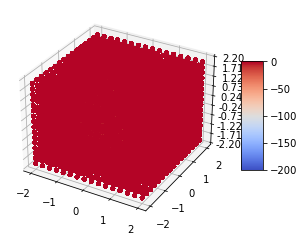

In [22]:
tiempoMostrado = 8 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

mostrado = np.where(t_TEST == np.unique(t_test)[19] )

sliced_1 = np.where(y_TEST < 0.1)
sliced_2 = np.where(y_TEST >-0.1)

sliced = np.intersect1d(sliced_1,sliced_2)

indsliced = np.intersect1d(mostrado,sliced)

error = np.abs(u_pred_sciann-u_pred_Num).flatten()[indsliced]
calor = u_pred_sciann.flatten()[indsliced]

X = x_data[:]
Y = y_data[:]
Z = z_data[:]


surf = ax.scatter(X, Y, Z, c=valCentro ,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
# ax.set_zlim(u_pred_sciann.min(), u_pred_sciann.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

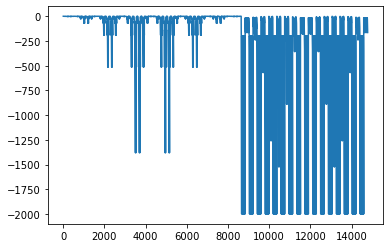

In [423]:
n

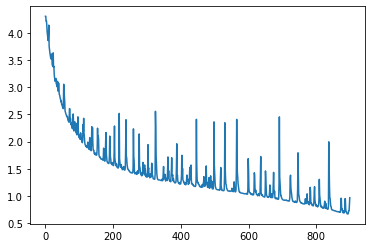

In [28]:
plt.plot(history.history['loss'][100:])

In [45]:
u_pred_sciann =  u.eval(m, [x_test, y_test, z_test, t_test])[:,0]
print(u_pred_sciann.shape)
print(u_pred_Num.shape)

(262000,)
(262000,)


In [46]:
MAE = np.mean(np.abs(u_pred_Num-u_pred_sciann))*640
RMSE = np.sqrt(np.mean((u_pred_Num-u_pred_sciann)**2))*640

pred = m.model.predict([np.reshape(x_test,(-1,)),np.reshape(y_test,(-1,)),np.reshape(z_test,(-1,)),np.reshape(t_test,(-1,))])

funcional =   np.mean(np.abs(np.array(pred[4])))

MAX = np.max(np.abs(u_pred_Num-u_pred_sciann))

In [47]:
MAE

227.57659719642308

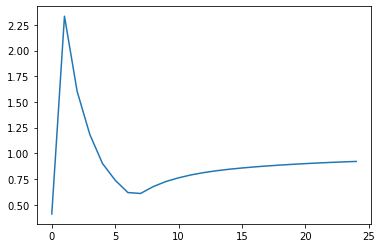

In [38]:
coord = 3
ordered_by_time = np.argsort(puntos_test[:,coord])
slices = np.unique(puntos_test[ordered_by_time,coord],return_index=True)[1][1:]
resultado = [np.max(np.abs(array)) for array in np.split(u_pred_sciann[ordered_by_time]-u_pred_Num[ordered_by_time],slices)]
plt.plot(resultado)

In [15]:
np.unique(t_test)

array([0.        , 0.20833333, 0.41666667, 0.625     , 0.83333333,
       1.04166667, 1.25      , 1.45833333, 1.66666667, 1.875     ,
       2.08333333, 2.29166667, 2.5       , 2.70833333, 2.91666667,
       3.125     , 3.33333333, 3.54166667, 3.75      , 3.95833333,
       4.16666667, 4.375     , 4.58333333, 4.79166667, 5.        ])

In [10]:
x_TEST, y_TEST, z_TEST, t_TEST = x_test.flatten(), y_test.flatten(), z_test.flatten(), t_test.flatten()


In [99]:
np.unique(t_test).shape

(20,)

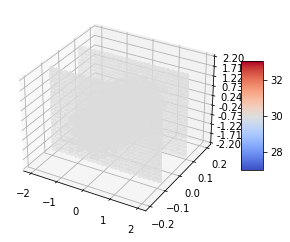

In [13]:
tiempoMostrado = 0 #Aquí se elige el segundo a mostrar

fig=plt.figure()
ax = fig.gca(projection='3d')

mostrado = np.where(t_TEST == np.unique(t_test)[0] )

sliced_1 = np.where(y_TEST < 0.2)
sliced_2 = np.where(y_TEST >-0.2)

sliced = np.intersect1d(sliced_1,sliced_2)

indsliced = np.intersect1d(mostrado,sliced)

calor1 = u_pred_Num.flatten()[indsliced]


X = x_TEST[indsliced]
Y = y_TEST[indsliced]
Z = z_TEST[indsliced]


surf = ax.scatter(X, Y, Z, c=calor1 ,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
# ax.set_zlim(u_pred_sciann.min(), u_pred_sciann.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [34]:
puntos_test.shape

(544680, 4)

In [105]:
xx = np.linspace(xmin, xmax, np.rint(xrange*denspt).astype(int) )
yy = np.array([0])
zz = np.linspace(zmin, zmax, np.rint(zrange*denspt).astype(int))
tt = np.array([5])

grid = np.meshgrid(xx,yy,zz,tt)

xx_cart, yy_cart, zz_cart, tt_cart = [ coord.flatten() for coord in grid]

puntos_cart = np.stack((xx_cart,yy_cart,zz_cart,tt_cart),axis=1)

#Uno ambas grids

puntos_test = puntos_cart

#Archivos de datos
u_file = 'u.txt'
mesh_file = 'cubo.mesh'
#Predicciones del numérico
puntos, valores = preparadatos(u_file,mesh_file)
print('Datos preparados')
u_pred_Num = griddata(puntos, valores, puntos_test , method='nearest')

Datos preparados


In [106]:
xx_2 = np.reshape(xx_cart,(24,24))
yy_2 = np.reshape(zz_cart,(24,24))

u_pred_Num_2 = np.reshape(u_pred_Num,(24,24))

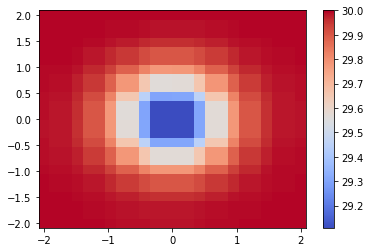

In [104]:
plt.pcolor(xx_2,yy_2,u_pred_Num_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Etapa0.png')

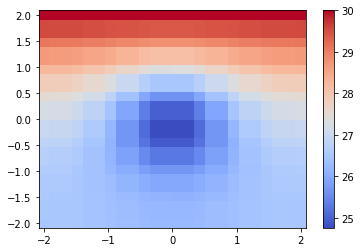

In [107]:
plt.pcolor(xx_2,yy_2,u_pred_Num_2,shading='auto',cmap=cm.coolwarm)
plt.colorbar()
plt.savefig('E3_Etapa5.png')

In [90]:
indsliced

array([163879, 163959, 164039, 164119, 164199, 164279, 164359, 164439,
       164519, 164599, 164679, 164759, 164839, 164919, 164999, 165079,
       165159, 165239, 165319, 165399, 165479, 165559, 165639, 165719,
       165799, 165879, 165959, 166039, 166119, 166199, 166279, 166359,
       166439, 166519, 166599, 166679, 166759, 166839, 166919, 166999,
       167079, 167159, 167239, 167319, 167399, 167479, 167559, 167639,
       167719, 167799, 167879, 167959, 168039, 168119, 168199, 168279,
       168359, 168439, 168519, 168599, 168679, 168759, 168839, 168919,
       168999, 169079, 169159, 169239, 169319, 169399, 169479, 169559,
       169639, 169719, 169799, 169879, 169959, 170039, 170119, 170199,
       170279, 170359, 170439, 170519, 170599, 170679, 170759, 170839,
       170919, 170999, 171079, 171159, 171239, 171319, 171399, 171479,
       171559, 171639, 171719, 171799, 171879, 171959, 172039, 172119,
       172199, 172279, 172359, 172439, 172519, 172599, 172679, 172759,
      